### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import warnings
import collections.abc
from itertools import repeat
from enum import Enum
from functools import partial

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10

from tqdm import tqdm, trange
from PIL import ImageFilter, ImageOps
import random
from torchvision import transforms
from timm.scheduler import CosineLRScheduler

torch.set_float32_matmul_precision('high')
from matplotlib import pyplot as plt 

from torch import Tensor
from torch.nn import functional as F, init
import math
from torch import jit

### Drop_Path, MLP, PatchEmb

In [2]:
class Polyn(nn.Module):
        
    __constants__ = ["in_features", "out_features"]
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(
            torch.empty((out_features, in_features), **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:

        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        squared_input = torch.pow(input, 2)
        return F.linear(squared_input, self.weight, self.bias)      

In [3]:
def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob

    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)

    return x * random_tensor

class Drop_path(nn.Module):
    def __init__(self, drop_prob: float=0.0, scale_by_keep: bool=True):
        super().__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

In [4]:
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):

    with torch.no_grad():
        def norm_cdf(x):
            return (1. + math.erf(x / math.sqrt(2.))) / 2.
        
        if (mean < a - 2 * std) or (mean > b + 2 * std):
            warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                        "The distribution of values may be incorrect.",
                        stacklevel=2)

        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        tensor.uniform_(2 * l - 1, 2 * u - 1)

        tensor.erfinv_()

        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        tensor.clamp_(min=a, max=b)
        return tensor

In [5]:
def _nturple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return tuple(x)
        return tuple(repeat(x, n))
    return parse

to_2tuple = _nturple(2)

In [6]:
class Format(str, Enum):
    NCHW = 'NCHW'
    NHWC = 'NHWC'
    NCL = 'NCL'
    NLC = 'NLC'

def nchw_to(x, fmt):
    if fmt == Format.NHCW:
        x = x.permute(0, 2, 3, 1)
    elif fmt == Format.NLC:
        x = x.flatten(2).transpose(1, 2)
    elif fmt == Format.NCL:
        x = x.flatten(2)
    return x

In [7]:
class PatchEmbed(nn.Module):
    def __init__(self,
                img_size=224,
                patch_size=16,
                in_channels=3,
                embed_dim=768,
                norm_layer=nn.Identity,
                flatten = True,
                output_fm = None,
                bias = True,
                strict_img_size: bool = True,
                dynamic_img_pad: bool = False,
                ):
        super().__init__()

        self.patch_size = to_2tuple(patch_size)
        self.img_size, self.gridSize, self.numPatches = self._init_img_size(img_size)

        if output_fm is not None:
            self.flatten = False
            self.output_fm = Format(output_fm)
        else:
            self.flatten = flatten
            self.output_fm = Format.NCHW
        
        self.strict_img_size = strict_img_size
        self.dynamic_img_pad = dynamic_img_pad


        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=bias)
        self.norm = norm_layer(embed_dim)

    def _init_img_size(self, img_size):
        if img_size is None:
            return None, None, None

        img_size = to_2tuple(img_size)
        grid_size = tuple([s // p for s, p in zip(img_size, self.patch_size)])
        num_patches = grid_size[0] * grid_size[1]

        return img_size, grid_size, num_patches

    def forward(self, x):
        B, C, H, W = x.shape

        assert self.img_size is not None
        assert self.img_size[0] == H == W
        if not self.dynamic_img_pad:
            assert H % self.patch_size[0] == 0

        if self.dynamic_img_pad:
            pad_h = (self.patch_size[0] - H % self.patch_size[0]) % self.patch_size[0]
            pad_w = (self.patch_size[1] - W % self.patch_size[1]) % self.patch_size[1]
            x = F.pad(x, (0, pad_w, 0, pad_h))

        x = self.proj(x)

        if self.flatten:
            x = x.flatten(2).transpose(1, 2)
        elif self.output_fm != Format.NCHW:
            x = nchw_to(x, self.output_fm)

        x = self.norm(x)
        return x


In [8]:
class Mlp(nn.Module):
    def __init__(self,  
                 in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.ReLU,
                 norm_layer=nn.Identity,
                 bias = True,
                 drop=0.,
                 use_conv = False):
        
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = to_2tuple(bias)
        drop = to_2tuple(drop)

        linear_layer = partial(nn.Conv2d, kernel_size=1) if use_conv else Polyn

        self.fc1 = linear_layer(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.dropFirst = nn.Dropout(drop[0])
        self.norm = norm_layer(hidden_features)
        self.fc2 = linear_layer(hidden_features, out_features, bias=bias[1])
        self.drop = nn.Dropout(drop[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = x**2 not squere :) 
        x = self.dropFirst(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

### Model, Attention, BaseBlock

In [9]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., qk_scale=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads

        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = Polyn(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)  
        self.proj = Polyn(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale

        attn = (q @ k.transpose(-2, -1))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Block(nn.Module):
    def __init__(self,
     dim,
     num_heads, 
     mlp_ratio=4., 
     qkv_bias=False, 
     drop=0., 
     attn_drop=0., 
     qkv_scale=None, 
     drop_path=0., 
     act_layer=nn.ReLU, 
     norm_layer=nn.LayerNorm,
     Attention=Attention,
     Mlp=Mlp,
     init_values=1e-4):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attention = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, qk_scale=qkv_scale)

        self.drop_path = Drop_path(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)


        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attention(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class Layer_scale_Block(nn.Module):
    def __init__(self,
     dim,
     num_heads, 
     mlp_ratio=4., 
     qkv_bias=False, 
     drop=0., 
     attn_drop=0., 
     qkv_scale=None, 
     drop_path=0., 
     act_layer=nn.ReLU, 
     norm_layer=nn.LayerNorm,
     Attention=Attention,
     Mlp=Mlp,
     init_values=1e-4):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, qk_scale=qkv_scale)
        self.drop_path = Drop_path(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)

        mlp_hidden = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden, act_layer=act_layer, drop=drop)

        self.gamma1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        self.gamma2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma1 * self.attn(self.norm1(x)))
        x = x + self.drop_path(self.gamma2 * self.mlp(self.norm2(x)))
        return x

class vitITSELF(nn.Module):
    def __init__(self,
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=10,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.,
    norm_layer=nn.LayerNorm,
    global_pool=None,
    block_layer = Block,
    PatchEmbed=PatchEmbed,
    act_layer=nn.ReLU,
    Attention=Attention,
    Mlp=Mlp,
    dpr=True,
    init_scale=1e-4,
    mlp_ratio_sth = 4.0,
    registers = 0,
    add_clfs = 0,
    **kwards):
        super().__init__()

        self.patchEMB = PatchEmbed(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)

        num_patches = self.patchEMB.numPatches

        self.drop_rate = drop_rate

        self.add_clfs = add_clfs

        self.clf = nn.Parameter(torch.zeros(1,add_clfs+1, embed_dim))
        # self.registers = nn.Parameter(torch.zeros(1,registers, embed_dim))
        self.posenc = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        dpr = [drop_path_rate for x in range(depth)] if dpr is True else drop_path_rate

        self.blocks = nn.ModuleList(
            [
                block_layer(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=0.0,
                    attn_drop=attn_drop_rate,
                    qkv_scale=qk_scale,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                    act_layer=act_layer,
                    Attention=Attention,
                    Mlp=Mlp,
                    init_values=init_scale
                )
                for i in range(depth)
            ]
        )

        self.norm = norm_layer(embed_dim)
        self.head = Polyn(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.posenc, std=.02)
        trunc_normal_(self.clf, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, Polyn):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, Polyn) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patchEMB(x)

        clfs = self.clf.expand(B, -1, -1)

        # regs = self.registers.expand(B, -1, -1)


        x = x + self.posenc
        # x = torch.cat((clfs, regs, x), dim=1)
        x = torch.cat((clfs, x), dim=1)

        for i , blk in enumerate(self.blocks):
            x = blk(x)

        x = self.norm(x)
        return torch.mean(x[:,0:self.add_clfs+1], dim=1)


    def forward(self, x):
        x = self.forward_features(x)

        if self.drop_rate > 0.:
            x = F.dropout(x, p=self.drop_rate, training=self.training)


        x = self.head(x)
        return x

In [10]:
def deit_base(img_size=224, patch_size=16, registers=0, add_clfs = 0, **kwards):
    model = vitITSELF(
        img_size=img_size,
        patch_size=patch_size,
        embed_dim=192, 
        depth=12, 
        num_heads=3,
        mlp_ratio=4.0,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        block_layer=Layer_scale_Block,
        registers = registers,
        add_clfs = add_clfs,
        **kwards
    )

    return model

### Transform, optimizer, sheduller, loss function

In [11]:
def create_sheduler(
    max_epoch,
    opt,
    mode = 'cosine',
    decay_epochs = 30,
    decay_milestones = (90, 180, 270),
    cooldown_epochs = 10,
    patience = 10,
    decay_rate = 0.1,
    min_lr = 1e-5,
    warmup_lr = 1e-6,
    warmup_epochs = 5,
    warmup_prefix = False, 
    noise = None,
    noise_pct = 0.67,
    noise_std = 1,
    noise_speed = 42,
    cycle_mul = 1,
    cycle_decay = 0.1,
    cycle_limit = 1,
    k_decay = 1,
    plateau_mode = 'max',
    step_on_epochs= True,
    updates_per_epoch= 0,
):
    global num_epochs
    t_init = max_epoch
    warmupT = warmup_epochs
    decayT = decay_epochs
    cooldownT = cooldown_epochs


    if not step_on_epochs:
        pass

    warmup_args = dict(
        warmup_lr_init = warmup_lr,
        warmup_t = warmupT,
        warmup_prefix = warmup_prefix
    )

    if noise is not None:
        if isinstance(noise, (list, tuple)):
            noiseRange = [n * t_init for n in noise]
            if len(noiseRange) == 1:
                noiseRange = noiseRange[0]
        else:
            noiseRange = noise * t_init
    else:
        noiseRange = None

    noise_args = dict(
        noise_range_t = noiseRange,
        noise_pct = noise_pct,
        noise_std = noise_std,
        noise_seed = noise_speed
    )

    cycle_args = dict(
        cycle_mul = cycle_mul,
        cycle_decay = cycle_decay,
        cycle_limit = cycle_limit,
    )

    lr_sceduler = None
    if mode == 'cosine':
        lr_sceduler = CosineLRScheduler(
            opt,
            t_initial = t_init,
            lr_min = min_lr,
            **warmup_args,
            **noise_args,
            **cycle_args,
            k_decay = k_decay,
        )
    else:
        raise NotImplementedError
    
    if hasattr(lr_sceduler, 'get_cycle_length'):

        t_with_cycles_and_cooldown = lr_sceduler.get_cycle_length() + cooldownT
        if step_on_epochs:
            num_epochs = t_with_cycles_and_cooldown
        else:
            num_epochs = t_with_cycles_and_cooldown // updates_per_epoch

    return lr_sceduler, num_epochs


In [12]:
def create_optim(
        model_params,
        opt: str = "adamw",
        lr = 5e-4,
        weight_decay = 0.05,
        momentum = 0.9,
        ):
    if opt == "adamw":
        optimizer = torch.optim.AdamW(model_params, lr=lr, weight_decay=weight_decay)
    elif opt == "sgd":
        optimizer = torch.optim.SGD(model_params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        raise NotImplementedError
    return optimizer

In [13]:
class GaussianBlur(object):
    def __init__(self, p=0.1, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max
    
    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img
        
        img = img.filter(
            ImageFilter.GaussianBlur(
                radius = random.uniform(self.radius_min, self.radius_max)
            )
        )
        return img
    
class Solarization(object):
    def __init__(self, p=0.2):
        self.p = p
    
    def __call__(self, img):
        if random.random() <= self.p:
            return ImageOps.solarize(img)
        
        return img
    
class grey_scale(object):
    def __init__(self, p=0.2):
        self.p = p
        self.transform = transforms.Grayscale(num_output_channels=3)
    
    def __call__(self, img):
        if random.random() <= self.p:
            return self.transform(img)
 
        return img

In [14]:
def new_transform(img_size = 32,
                remove_random_resized_crop = True,
                color_jitter = 0.3):

    MEAN, STD = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618], [0.24703225141799082, 0.24348516474564, 0.26158783926049628]
    primary = []

    if remove_random_resized_crop:
        primary = [
            transforms.Resize(img_size, interpolation=3),  
            transforms.RandomCrop(img_size, padding=4, padding_mode="reflect"),
            transforms.RandomHorizontalFlip()
        ]
    else:
        primary = [
            transforms.ToTensor()
        ]
    
    secondary = [
        transforms.RandomChoice([
            grey_scale(p=1),
            Solarization(p=1),
            GaussianBlur(p=1),
        ])
    ]

    if color_jitter is not None and color_jitter != 0:
        secondary.append(
            transforms.ColorJitter(
                color_jitter, color_jitter, color_jitter
            )
        )

    final = [
        transforms.ToTensor(),
        transforms.Normalize(mean=torch.tensor(MEAN), std=torch.tensor(STD))
    ]
    return transforms.Compose(primary + secondary + final)

In [15]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing = 0.1):
        super().__init__()
        assert smoothing < 1.0

        self.smoothing = smoothing
    
    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nllLoss = - logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = - logprobs.mean(dim=-1)
        loss = (1-self.smoothing)*nllLoss + self.smoothing*smooth_loss
        return loss.mean()

### Dataset

In [16]:
transform = new_transform()

train_set = CIFAR10(root='./cifar', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./cifar', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=68)
test_loader = DataLoader(test_set, shuffle=False, batch_size=68)

Files already downloaded and verified
Files already downloaded and verified


### Activation Maps

In [17]:
activation_maps = {}

In [18]:
def hook_fn(module, input, output, number):
    layer_name = f'{module.__class__.__name__}_{number}'
    activation_maps[layer_name] = output[0,:,:].mean(dim=1)[1:].reshape(16,16)

def register_hooks(model):
    model.blocks[0].mlp.act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 0))
    model.blocks[5].mlp.act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 5))
    model.blocks[11].mlp.act.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 11)) 

def save_activation_maps(epoch):
    for layer_name, activation in activation_maps.items():
        activation = activation.detach().cpu().numpy()
        plt.figure(figsize=(10, 5))
        plt.imshow(activation, cmap='viridis')
        plt.title(f'Activation Map for {layer_name} at Epoch {epoch} ({PREFIX})')
        plt.colorbar()
        plt.savefig(f'{PREFIX}/{layer_name}_activation_map_epoch_{epoch}.png') 
        plt.close()

### Train and Evaluate

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
def train(model, checkpoint=None):

    model = model
    N_EPOCHS = 800

    optimizer = create_optim(model.parameters(), lr = 3e-3, weight_decay=0.05, )
    scheduler, _ = create_sheduler(N_EPOCHS, optimizer, mode='cosine', warmup_epochs=5, warmup_lr=1e-6)
    criterion = LabelSmoothingCrossEntropy()

    training_losses = []

    if checkpoint is not None:
        checkpoint = torch.load(checkpoint, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        N_EPOCHS -= checkpoint['epoch']
        
        scheduler, _ = create_sheduler(N_EPOCHS, optimizer, mode='cosine', warmup_epochs=5, warmup_lr=1e-6)
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        criterion = LabelSmoothingCrossEntropy()

        training_losses = checkpoint['training_losses']
        best_loss = checkpoint['loss']

    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for i, batch in tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1} in training", leave=False):

            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step(epoch)

        if epoch % 100 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': train_loss, 
                'training_losses': training_losses
            }
  
            best_loss = train_loss

            torch.save(checkpoint, 'checkpoint.pt')

            # writer.add_scalar('training loss', train_loss / 100, epoch * len(train_loader) + i)

            save_activation_maps(epoch)


        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
        print()


        training_losses.append(train_loss)

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

        accuracy = correct / total * 100

    return test_loss, correct, total, training_losses

torch.Size([128, 257, 768])  --- (B, H*W+1, EMBED_DIM)

In [21]:
PREFIX = 'polyn_relu'

import os

os.makedirs(f"{PREFIX}", exist_ok=True)

model = deit_base(img_size=32, patch_size=2, drop_path=0.2, act_layer=nn.ReLU).to(device)
register_hooks(model)

model = torch.compile(model)

test_loss, correct, total, training_losses = train(model)       

Training:   0%|          | 1/800 [01:55<25:40:31, 115.68s/it]

Epoch 1/800 loss: 2.32



Training:   0%|          | 2/800 [03:32<23:08:11, 104.38s/it]

Epoch 2/800 loss: 2.30



Training:   0%|          | 3/800 [05:08<22:19:25, 100.83s/it]

Epoch 3/800 loss: 2.09



Training:   0%|          | 4/800 [06:43<21:48:18, 98.62s/it] 

Epoch 4/800 loss: 2.01



Training:   1%|          | 5/800 [08:19<21:29:50, 97.35s/it]

Epoch 5/800 loss: 1.97



Training:   1%|          | 6/800 [09:54<21:18:05, 96.58s/it]

Epoch 6/800 loss: 1.92



Training:   1%|          | 7/800 [11:29<21:10:08, 96.10s/it]

Epoch 7/800 loss: 1.86



Training:   1%|          | 8/800 [13:04<21:04:02, 95.76s/it]

Epoch 8/800 loss: 1.79



Training:   1%|          | 9/800 [14:39<20:59:34, 95.54s/it]

Epoch 9/800 loss: 1.74



Training:   1%|▏         | 10/800 [16:14<20:55:41, 95.37s/it]

Epoch 10/800 loss: 1.70



Training:   1%|▏         | 11/800 [17:49<20:52:59, 95.28s/it]

Epoch 11/800 loss: 1.66



Training:   2%|▏         | 12/800 [19:24<20:50:00, 95.18s/it]

Epoch 12/800 loss: 1.63



Training:   2%|▏         | 13/800 [20:59<20:47:48, 95.13s/it]

Epoch 13/800 loss: 1.61



Training:   2%|▏         | 14/800 [22:34<20:45:46, 95.10s/it]

Epoch 14/800 loss: 1.59



Training:   2%|▏         | 15/800 [24:09<20:44:17, 95.11s/it]

Epoch 15/800 loss: 1.57



Training:   2%|▏         | 16/800 [25:44<20:42:45, 95.11s/it]

Epoch 16/800 loss: 1.56



Training:   2%|▏         | 17/800 [27:19<20:41:05, 95.10s/it]

Epoch 17/800 loss: 1.55



Training:   2%|▏         | 18/800 [28:54<20:39:23, 95.09s/it]

Epoch 18/800 loss: 1.54



Training:   2%|▏         | 19/800 [30:29<20:37:47, 95.09s/it]

Epoch 19/800 loss: 1.53



Training:   2%|▎         | 20/800 [32:04<20:36:05, 95.08s/it]

Epoch 20/800 loss: 1.52



Training:   3%|▎         | 21/800 [33:40<20:34:36, 95.09s/it]

Epoch 21/800 loss: 1.52



Training:   3%|▎         | 22/800 [35:15<20:32:26, 95.05s/it]

Epoch 22/800 loss: 1.51



Training:   3%|▎         | 23/800 [36:50<20:31:00, 95.06s/it]

Epoch 23/800 loss: 1.51



Training:   3%|▎         | 24/800 [38:25<20:29:29, 95.06s/it]

Epoch 24/800 loss: 1.50



Training:   3%|▎         | 25/800 [40:00<20:28:26, 95.10s/it]

Epoch 25/800 loss: 1.49



Training:   3%|▎         | 26/800 [41:35<20:27:15, 95.14s/it]

Epoch 26/800 loss: 1.49



Training:   3%|▎         | 27/800 [43:10<20:25:34, 95.13s/it]

Epoch 27/800 loss: 1.48



Training:   4%|▎         | 28/800 [44:45<20:24:03, 95.13s/it]

Epoch 28/800 loss: 1.48



Training:   4%|▎         | 29/800 [46:20<20:22:26, 95.13s/it]

Epoch 29/800 loss: 1.47



Training:   4%|▍         | 30/800 [47:56<20:20:56, 95.14s/it]

Epoch 30/800 loss: 1.47



Training:   4%|▍         | 31/800 [49:31<20:19:25, 95.14s/it]

Epoch 31/800 loss: 1.47



Training:   4%|▍         | 32/800 [51:06<20:17:10, 95.09s/it]

Epoch 32/800 loss: 1.46



Training:   4%|▍         | 33/800 [52:41<20:15:53, 95.12s/it]

Epoch 33/800 loss: 1.46



Training:   4%|▍         | 34/800 [54:16<20:13:33, 95.06s/it]

Epoch 34/800 loss: 1.45



Training:   4%|▍         | 35/800 [55:51<20:12:13, 95.08s/it]

Epoch 35/800 loss: 1.46



Training:   4%|▍         | 36/800 [57:26<20:11:13, 95.12s/it]

Epoch 36/800 loss: 1.45



Training:   5%|▍         | 37/800 [59:01<20:09:47, 95.13s/it]

Epoch 37/800 loss: 1.45



Training:   5%|▍         | 38/800 [1:00:37<20:08:33, 95.16s/it]

Epoch 38/800 loss: 1.45



Training:   5%|▍         | 39/800 [1:02:12<20:06:48, 95.15s/it]

Epoch 39/800 loss: 1.44



Training:   5%|▌         | 40/800 [1:03:47<20:05:02, 95.13s/it]

Epoch 40/800 loss: 1.44



Training:   5%|▌         | 41/800 [1:05:22<20:03:06, 95.11s/it]

Epoch 41/800 loss: 1.44



Training:   5%|▌         | 42/800 [1:06:57<20:01:08, 95.08s/it]

Epoch 42/800 loss: 1.44



Training:   5%|▌         | 43/800 [1:08:32<19:59:09, 95.05s/it]

Epoch 43/800 loss: 1.43



Training:   6%|▌         | 44/800 [1:10:07<19:57:17, 95.02s/it]

Epoch 44/800 loss: 1.43



Training:   6%|▌         | 45/800 [1:11:42<19:55:37, 95.02s/it]

Epoch 45/800 loss: 1.43



Training:   6%|▌         | 46/800 [1:13:17<19:53:43, 94.99s/it]

Epoch 46/800 loss: 1.43



Training:   6%|▌         | 47/800 [1:14:52<19:52:12, 95.00s/it]

Epoch 47/800 loss: 1.43



Training:   6%|▌         | 48/800 [1:16:27<19:51:13, 95.05s/it]

Epoch 48/800 loss: 1.43



Training:   6%|▌         | 49/800 [1:18:02<19:49:46, 95.06s/it]

Epoch 49/800 loss: 1.43



Training:   6%|▋         | 50/800 [1:19:37<19:48:33, 95.08s/it]

Epoch 50/800 loss: 1.42



Training:   6%|▋         | 51/800 [1:21:12<19:47:03, 95.09s/it]

Epoch 51/800 loss: 1.42



Training:   6%|▋         | 52/800 [1:22:47<19:45:07, 95.06s/it]

Epoch 52/800 loss: 1.42



Training:   7%|▋         | 53/800 [1:24:22<19:43:21, 95.05s/it]

Epoch 53/800 loss: 1.42



Training:   7%|▋         | 54/800 [1:25:57<19:41:48, 95.05s/it]

Epoch 54/800 loss: 1.42



Training:   7%|▋         | 55/800 [1:27:32<19:40:17, 95.06s/it]

Epoch 55/800 loss: 1.42



Training:   7%|▋         | 56/800 [1:29:07<19:38:32, 95.04s/it]

Epoch 56/800 loss: 1.41



Training:   7%|▋         | 57/800 [1:30:42<19:37:07, 95.06s/it]

Epoch 57/800 loss: 1.42



Training:   7%|▋         | 58/800 [1:32:17<19:34:58, 95.01s/it]

Epoch 58/800 loss: 1.41



Training:   7%|▋         | 59/800 [1:33:53<19:33:56, 95.06s/it]

Epoch 59/800 loss: 1.41



Training:   8%|▊         | 60/800 [1:35:28<19:32:44, 95.09s/it]

Epoch 60/800 loss: 1.41



Training:   8%|▊         | 61/800 [1:37:03<19:31:05, 95.08s/it]

Epoch 61/800 loss: 1.40



Training:   8%|▊         | 62/800 [1:38:38<19:29:43, 95.10s/it]

Epoch 62/800 loss: 1.40



Training:   8%|▊         | 63/800 [1:40:13<19:28:00, 95.09s/it]

Epoch 63/800 loss: 1.40



Training:   8%|▊         | 64/800 [1:41:48<19:26:35, 95.10s/it]

Epoch 64/800 loss: 1.40



Training:   8%|▊         | 65/800 [1:43:23<19:24:58, 95.10s/it]

Epoch 65/800 loss: 1.40



Training:   8%|▊         | 66/800 [1:44:58<19:23:23, 95.10s/it]

Epoch 66/800 loss: 1.40



Training:   8%|▊         | 67/800 [1:46:33<19:21:48, 95.10s/it]

Epoch 67/800 loss: 1.40



Training:   8%|▊         | 68/800 [1:48:08<19:20:05, 95.09s/it]

Epoch 68/800 loss: 1.40



Training:   9%|▊         | 69/800 [1:49:44<19:18:21, 95.08s/it]

Epoch 69/800 loss: 1.39



Training:   9%|▉         | 70/800 [1:51:19<19:16:54, 95.09s/it]

Epoch 70/800 loss: 1.40



Training:   9%|▉         | 71/800 [1:52:54<19:15:33, 95.11s/it]

Epoch 71/800 loss: 1.39



Training:   9%|▉         | 72/800 [1:54:29<19:14:06, 95.12s/it]

Epoch 72/800 loss: 1.40



Training:   9%|▉         | 73/800 [1:56:04<19:12:25, 95.11s/it]

Epoch 73/800 loss: 1.40



Training:   9%|▉         | 74/800 [1:57:39<19:10:49, 95.11s/it]

Epoch 74/800 loss: 1.40



Training:   9%|▉         | 75/800 [1:59:14<19:08:55, 95.08s/it]

Epoch 75/800 loss: 1.39



Training:  10%|▉         | 76/800 [2:00:49<19:07:41, 95.11s/it]

Epoch 76/800 loss: 1.39



Training:  10%|▉         | 77/800 [2:02:25<19:06:22, 95.13s/it]

Epoch 77/800 loss: 1.39



Training:  10%|▉         | 78/800 [2:04:00<19:04:19, 95.10s/it]

Epoch 78/800 loss: 1.38



Training:  10%|▉         | 79/800 [2:05:35<19:02:19, 95.06s/it]

Epoch 79/800 loss: 1.39



Training:  10%|█         | 80/800 [2:07:10<19:01:07, 95.09s/it]

Epoch 80/800 loss: 1.39



Training:  10%|█         | 81/800 [2:08:45<18:59:54, 95.12s/it]

Epoch 81/800 loss: 1.39



Training:  10%|█         | 82/800 [2:10:20<18:58:27, 95.14s/it]

Epoch 82/800 loss: 1.39



Training:  10%|█         | 83/800 [2:11:55<18:56:55, 95.14s/it]

Epoch 83/800 loss: 1.38



Training:  10%|█         | 84/800 [2:13:30<18:55:15, 95.13s/it]

Epoch 84/800 loss: 1.38



Training:  11%|█         | 85/800 [2:15:05<18:53:07, 95.09s/it]

Epoch 85/800 loss: 1.38



Training:  11%|█         | 86/800 [2:16:40<18:51:31, 95.09s/it]

Epoch 86/800 loss: 1.38



Training:  11%|█         | 87/800 [2:18:15<18:49:18, 95.03s/it]

Epoch 87/800 loss: 1.38



Training:  11%|█         | 88/800 [2:19:50<18:48:00, 95.06s/it]

Epoch 88/800 loss: 1.38



Training:  11%|█         | 89/800 [2:21:25<18:45:59, 95.02s/it]

Epoch 89/800 loss: 1.38



Training:  11%|█▏        | 90/800 [2:23:00<18:44:14, 95.01s/it]

Epoch 90/800 loss: 1.38



Training:  11%|█▏        | 91/800 [2:24:35<18:42:47, 95.02s/it]

Epoch 91/800 loss: 1.38



Training:  12%|█▏        | 92/800 [2:26:11<18:41:47, 95.07s/it]

Epoch 92/800 loss: 1.38



Training:  12%|█▏        | 93/800 [2:27:46<18:40:54, 95.13s/it]

Epoch 93/800 loss: 1.37



Training:  12%|█▏        | 94/800 [2:29:21<18:39:12, 95.12s/it]

Epoch 94/800 loss: 1.37



Training:  12%|█▏        | 95/800 [2:30:56<18:37:38, 95.12s/it]

Epoch 95/800 loss: 1.38



Training:  12%|█▏        | 96/800 [2:32:31<18:34:50, 95.02s/it]

Epoch 96/800 loss: 1.38



Training:  12%|█▏        | 97/800 [2:34:06<18:33:16, 95.02s/it]

Epoch 97/800 loss: 1.37



Training:  12%|█▏        | 98/800 [2:35:41<18:31:59, 95.04s/it]

Epoch 98/800 loss: 1.37



Training:  12%|█▏        | 99/800 [2:37:16<18:30:15, 95.03s/it]

Epoch 99/800 loss: 1.37



Training:  12%|█▎        | 100/800 [2:38:51<18:28:45, 95.04s/it]

Epoch 100/800 loss: 1.37



Training:  13%|█▎        | 101/800 [2:40:27<18:29:57, 95.28s/it]

Epoch 101/800 loss: 1.36



Training:  13%|█▎        | 102/800 [2:42:02<18:27:32, 95.20s/it]

Epoch 102/800 loss: 1.36



Training:  13%|█▎        | 103/800 [2:43:37<18:25:45, 95.19s/it]

Epoch 103/800 loss: 1.37



Training:  13%|█▎        | 104/800 [2:45:12<18:24:04, 95.18s/it]

Epoch 104/800 loss: 1.36



Training:  13%|█▎        | 105/800 [2:46:47<18:22:12, 95.15s/it]

Epoch 105/800 loss: 1.37



Training:  13%|█▎        | 106/800 [2:48:22<18:20:24, 95.14s/it]

Epoch 106/800 loss: 1.37



Training:  13%|█▎        | 107/800 [2:49:57<18:18:34, 95.11s/it]

Epoch 107/800 loss: 1.36



Training:  14%|█▎        | 108/800 [2:51:33<18:17:15, 95.14s/it]

Epoch 108/800 loss: 1.36



Training:  14%|█▎        | 109/800 [2:53:08<18:15:11, 95.10s/it]

Epoch 109/800 loss: 1.37



Training:  14%|█▍        | 110/800 [2:54:43<18:13:27, 95.08s/it]

Epoch 110/800 loss: 1.36



Training:  14%|█▍        | 111/800 [2:56:18<18:11:17, 95.03s/it]

Epoch 111/800 loss: 1.36



Training:  14%|█▍        | 112/800 [2:57:53<18:09:55, 95.05s/it]

Epoch 112/800 loss: 1.36



Training:  14%|█▍        | 113/800 [2:59:28<18:08:55, 95.10s/it]

Epoch 113/800 loss: 1.36



Training:  14%|█▍        | 114/800 [3:01:03<18:07:28, 95.11s/it]

Epoch 114/800 loss: 1.36



Training:  14%|█▍        | 115/800 [3:02:38<18:06:00, 95.13s/it]

Epoch 115/800 loss: 1.36



Training:  14%|█▍        | 116/800 [3:04:13<18:04:31, 95.13s/it]

Epoch 116/800 loss: 1.36



Training:  15%|█▍        | 117/800 [3:05:48<18:03:03, 95.14s/it]

Epoch 117/800 loss: 1.36



Training:  15%|█▍        | 118/800 [3:07:24<18:01:04, 95.11s/it]

Epoch 118/800 loss: 1.36



Training:  15%|█▍        | 119/800 [3:08:59<17:59:41, 95.13s/it]

Epoch 119/800 loss: 1.35



Training:  15%|█▌        | 120/800 [3:10:34<17:58:07, 95.13s/it]

Epoch 120/800 loss: 1.36



Training:  15%|█▌        | 121/800 [3:12:09<17:56:36, 95.13s/it]

Epoch 121/800 loss: 1.35



Training:  15%|█▌        | 122/800 [3:13:44<17:55:10, 95.15s/it]

Epoch 122/800 loss: 1.35



Training:  15%|█▌        | 123/800 [3:15:19<17:52:48, 95.08s/it]

Epoch 123/800 loss: 1.35



Training:  16%|█▌        | 124/800 [3:16:54<17:51:29, 95.10s/it]

Epoch 124/800 loss: 1.35



Training:  16%|█▌        | 125/800 [3:18:29<17:50:06, 95.12s/it]

Epoch 125/800 loss: 1.35



Training:  16%|█▌        | 126/800 [3:20:05<17:48:36, 95.13s/it]

Epoch 126/800 loss: 1.35



Training:  16%|█▌        | 127/800 [3:21:40<17:46:59, 95.13s/it]

Epoch 127/800 loss: 1.35



Training:  16%|█▌        | 128/800 [3:23:15<17:45:14, 95.11s/it]

Epoch 128/800 loss: 1.35



Training:  16%|█▌        | 129/800 [3:24:50<17:43:42, 95.12s/it]

Epoch 129/800 loss: 1.35



Training:  16%|█▋        | 130/800 [3:26:25<17:41:44, 95.08s/it]

Epoch 130/800 loss: 1.34



Training:  16%|█▋        | 131/800 [3:28:00<17:39:46, 95.05s/it]

Epoch 131/800 loss: 1.34



Training:  16%|█▋        | 132/800 [3:29:35<17:38:03, 95.04s/it]

Epoch 132/800 loss: 1.34



Training:  17%|█▋        | 133/800 [3:31:10<17:36:11, 95.01s/it]

Epoch 133/800 loss: 1.34



Training:  17%|█▋        | 134/800 [3:32:45<17:34:40, 95.02s/it]

Epoch 134/800 loss: 1.34



Training:  17%|█▋        | 135/800 [3:34:20<17:32:52, 95.00s/it]

Epoch 135/800 loss: 1.35



Training:  17%|█▋        | 136/800 [3:35:55<17:31:53, 95.05s/it]

Epoch 136/800 loss: 1.34



Training:  17%|█▋        | 137/800 [3:37:30<17:30:38, 95.08s/it]

Epoch 137/800 loss: 1.34



Training:  17%|█▋        | 138/800 [3:39:05<17:29:10, 95.09s/it]

Epoch 138/800 loss: 1.34



Training:  17%|█▋        | 139/800 [3:40:40<17:27:25, 95.08s/it]

Epoch 139/800 loss: 1.34



Training:  18%|█▊        | 140/800 [3:42:15<17:25:38, 95.06s/it]

Epoch 140/800 loss: 1.34



Training:  18%|█▊        | 141/800 [3:43:50<17:24:14, 95.07s/it]

Epoch 141/800 loss: 1.34



Training:  18%|█▊        | 142/800 [3:45:25<17:22:33, 95.07s/it]

Epoch 142/800 loss: 1.34



Training:  18%|█▊        | 143/800 [3:47:00<17:20:54, 95.06s/it]

Epoch 143/800 loss: 1.34



Training:  18%|█▊        | 144/800 [3:48:36<17:19:14, 95.05s/it]

Epoch 144/800 loss: 1.34



Training:  18%|█▊        | 145/800 [3:50:11<17:17:36, 95.05s/it]

Epoch 145/800 loss: 1.33



Training:  18%|█▊        | 146/800 [3:51:46<17:16:20, 95.08s/it]

Epoch 146/800 loss: 1.34



Training:  18%|█▊        | 147/800 [3:53:21<17:15:05, 95.11s/it]

Epoch 147/800 loss: 1.34



Training:  18%|█▊        | 148/800 [3:54:56<17:13:32, 95.11s/it]

Epoch 148/800 loss: 1.33



Training:  19%|█▊        | 149/800 [3:56:31<17:11:55, 95.11s/it]

Epoch 149/800 loss: 1.33



Training:  19%|█▉        | 150/800 [3:58:06<17:10:20, 95.11s/it]

Epoch 150/800 loss: 1.33



Training:  19%|█▉        | 151/800 [3:59:41<17:08:49, 95.11s/it]

Epoch 151/800 loss: 1.33



Training:  19%|█▉        | 152/800 [4:01:16<17:07:12, 95.11s/it]

Epoch 152/800 loss: 1.33



Training:  19%|█▉        | 153/800 [4:02:52<17:05:37, 95.11s/it]

Epoch 153/800 loss: 1.33



Training:  19%|█▉        | 154/800 [4:04:27<17:03:51, 95.10s/it]

Epoch 154/800 loss: 1.32



Training:  19%|█▉        | 155/800 [4:06:02<17:02:25, 95.11s/it]

Epoch 155/800 loss: 1.33



Training:  20%|█▉        | 156/800 [4:07:37<17:00:44, 95.10s/it]

Epoch 156/800 loss: 1.33



Training:  20%|█▉        | 157/800 [4:09:12<16:58:59, 95.08s/it]

Epoch 157/800 loss: 1.33



Training:  20%|█▉        | 158/800 [4:10:47<16:57:37, 95.10s/it]

Epoch 158/800 loss: 1.33



Training:  20%|█▉        | 159/800 [4:12:22<16:56:07, 95.11s/it]

Epoch 159/800 loss: 1.33



Training:  20%|██        | 160/800 [4:13:57<16:54:48, 95.14s/it]

Epoch 160/800 loss: 1.32



Training:  20%|██        | 161/800 [4:15:32<16:53:14, 95.14s/it]

Epoch 161/800 loss: 1.32



Training:  20%|██        | 162/800 [4:17:08<16:51:22, 95.11s/it]

Epoch 162/800 loss: 1.33



Training:  20%|██        | 163/800 [4:18:43<16:49:45, 95.11s/it]

Epoch 163/800 loss: 1.32



Training:  20%|██        | 164/800 [4:20:18<16:47:48, 95.08s/it]

Epoch 164/800 loss: 1.32



Training:  21%|██        | 165/800 [4:21:53<16:46:08, 95.07s/it]

Epoch 165/800 loss: 1.33



Training:  21%|██        | 166/800 [4:23:28<16:44:12, 95.04s/it]

Epoch 166/800 loss: 1.32



Training:  21%|██        | 167/800 [4:25:03<16:42:58, 95.07s/it]

Epoch 167/800 loss: 1.32



Training:  21%|██        | 168/800 [4:26:38<16:41:24, 95.07s/it]

Epoch 168/800 loss: 1.33



Training:  21%|██        | 169/800 [4:28:13<16:40:10, 95.10s/it]

Epoch 169/800 loss: 1.32



Training:  21%|██▏       | 170/800 [4:29:48<16:38:41, 95.11s/it]

Epoch 170/800 loss: 1.32



Training:  21%|██▏       | 171/800 [4:31:23<16:37:04, 95.11s/it]

Epoch 171/800 loss: 1.32



Training:  22%|██▏       | 172/800 [4:32:58<16:35:24, 95.10s/it]

Epoch 172/800 loss: 1.32



Training:  22%|██▏       | 173/800 [4:34:34<16:33:52, 95.11s/it]

Epoch 173/800 loss: 1.32



Training:  22%|██▏       | 174/800 [4:36:09<16:31:59, 95.08s/it]

Epoch 174/800 loss: 1.32



Training:  22%|██▏       | 175/800 [4:37:44<16:30:15, 95.06s/it]

Epoch 175/800 loss: 1.32



Training:  22%|██▏       | 176/800 [4:39:19<16:28:24, 95.04s/it]

Epoch 176/800 loss: 1.31



Training:  22%|██▏       | 177/800 [4:40:54<16:26:45, 95.03s/it]

Epoch 177/800 loss: 1.31



Training:  22%|██▏       | 178/800 [4:42:28<16:24:51, 95.00s/it]

Epoch 178/800 loss: 1.31



Training:  22%|██▏       | 179/800 [4:44:04<16:23:24, 95.02s/it]

Epoch 179/800 loss: 1.31



Training:  22%|██▎       | 180/800 [4:45:39<16:22:07, 95.05s/it]

Epoch 180/800 loss: 1.31



Training:  23%|██▎       | 181/800 [4:47:14<16:20:52, 95.08s/it]

Epoch 181/800 loss: 1.31



Training:  23%|██▎       | 182/800 [4:48:49<16:19:30, 95.10s/it]

Epoch 182/800 loss: 1.31



Training:  23%|██▎       | 183/800 [4:50:24<16:17:44, 95.08s/it]

Epoch 183/800 loss: 1.31



Training:  23%|██▎       | 184/800 [4:51:59<16:16:08, 95.08s/it]

Epoch 184/800 loss: 1.31



Training:  23%|██▎       | 185/800 [4:53:34<16:14:32, 95.08s/it]

Epoch 185/800 loss: 1.31



Training:  23%|██▎       | 186/800 [4:55:09<16:12:48, 95.06s/it]

Epoch 186/800 loss: 1.31



Training:  23%|██▎       | 187/800 [4:56:44<16:11:18, 95.07s/it]

Epoch 187/800 loss: 1.31



Training:  24%|██▎       | 188/800 [4:58:19<16:09:19, 95.03s/it]

Epoch 188/800 loss: 1.31



Training:  24%|██▎       | 189/800 [4:59:54<16:07:52, 95.04s/it]

Epoch 189/800 loss: 1.31



Training:  24%|██▍       | 190/800 [5:01:29<16:05:58, 95.01s/it]

Epoch 190/800 loss: 1.31



Training:  24%|██▍       | 191/800 [5:03:04<16:04:46, 95.05s/it]

Epoch 191/800 loss: 1.30



Training:  24%|██▍       | 192/800 [5:04:39<16:03:29, 95.08s/it]

Epoch 192/800 loss: 1.30



Training:  24%|██▍       | 193/800 [5:06:15<16:02:04, 95.10s/it]

Epoch 193/800 loss: 1.31



Training:  24%|██▍       | 194/800 [5:07:50<16:00:29, 95.10s/it]

Epoch 194/800 loss: 1.31



Training:  24%|██▍       | 195/800 [5:09:25<15:58:55, 95.10s/it]

Epoch 195/800 loss: 1.31



Training:  24%|██▍       | 196/800 [5:11:00<15:57:26, 95.11s/it]

Epoch 196/800 loss: 1.30



Training:  25%|██▍       | 197/800 [5:12:35<15:55:55, 95.12s/it]

Epoch 197/800 loss: 1.30



Training:  25%|██▍       | 198/800 [5:14:10<15:53:53, 95.07s/it]

Epoch 198/800 loss: 1.30



Training:  25%|██▍       | 199/800 [5:15:45<15:52:31, 95.09s/it]

Epoch 199/800 loss: 1.30



Training:  25%|██▌       | 200/800 [5:17:20<15:51:04, 95.11s/it]

Epoch 200/800 loss: 1.30



Training:  25%|██▌       | 201/800 [5:18:56<15:51:50, 95.34s/it]

Epoch 201/800 loss: 1.30



Training:  25%|██▌       | 202/800 [5:20:31<15:49:49, 95.30s/it]

Epoch 202/800 loss: 1.30



Training:  25%|██▌       | 203/800 [5:22:07<15:47:47, 95.26s/it]

Epoch 203/800 loss: 1.30



Training:  26%|██▌       | 204/800 [5:23:42<15:45:51, 95.22s/it]

Epoch 204/800 loss: 1.30



Training:  26%|██▌       | 205/800 [5:25:17<15:44:13, 95.22s/it]

Epoch 205/800 loss: 1.30



Training:  26%|██▌       | 206/800 [5:26:52<15:42:21, 95.19s/it]

Epoch 206/800 loss: 1.30



Training:  26%|██▌       | 207/800 [5:28:27<15:40:29, 95.16s/it]

Epoch 207/800 loss: 1.30



Training:  26%|██▌       | 208/800 [5:30:02<15:38:48, 95.15s/it]

Epoch 208/800 loss: 1.29



Training:  26%|██▌       | 209/800 [5:31:37<15:37:09, 95.14s/it]

Epoch 209/800 loss: 1.29



Training:  26%|██▋       | 210/800 [5:33:13<15:35:42, 95.16s/it]

Epoch 210/800 loss: 1.29



Training:  26%|██▋       | 211/800 [5:34:48<15:33:49, 95.13s/it]

Epoch 211/800 loss: 1.29



Training:  26%|██▋       | 212/800 [5:36:23<15:31:33, 95.06s/it]

Epoch 212/800 loss: 1.29



Training:  27%|██▋       | 213/800 [5:37:58<15:30:17, 95.09s/it]

Epoch 213/800 loss: 1.29



Training:  27%|██▋       | 214/800 [5:39:33<15:28:49, 95.10s/it]

Epoch 214/800 loss: 1.29



Training:  27%|██▋       | 215/800 [5:41:08<15:27:17, 95.11s/it]

Epoch 215/800 loss: 1.29



Training:  27%|██▋       | 216/800 [5:42:43<15:25:37, 95.10s/it]

Epoch 216/800 loss: 1.29



Training:  27%|██▋       | 217/800 [5:44:18<15:23:58, 95.09s/it]

Epoch 217/800 loss: 1.29



Training:  27%|██▋       | 218/800 [5:45:53<15:22:10, 95.07s/it]

Epoch 218/800 loss: 1.29



Training:  27%|██▋       | 219/800 [5:47:28<15:20:25, 95.05s/it]

Epoch 219/800 loss: 1.29



Training:  28%|██▊       | 220/800 [5:49:03<15:18:34, 95.02s/it]

Epoch 220/800 loss: 1.28



Training:  28%|██▊       | 221/800 [5:50:38<15:17:00, 95.03s/it]

Epoch 221/800 loss: 1.29



Training:  28%|██▊       | 222/800 [5:52:13<15:15:07, 95.00s/it]

Epoch 222/800 loss: 1.29



Training:  28%|██▊       | 223/800 [5:53:48<15:13:44, 95.02s/it]

Epoch 223/800 loss: 1.28



Training:  28%|██▊       | 224/800 [5:55:23<15:12:05, 95.01s/it]

Epoch 224/800 loss: 1.29



Training:  28%|██▊       | 225/800 [5:56:58<15:10:44, 95.03s/it]

Epoch 225/800 loss: 1.28



Training:  28%|██▊       | 226/800 [5:58:33<15:09:23, 95.06s/it]

Epoch 226/800 loss: 1.28



Training:  28%|██▊       | 227/800 [6:00:08<15:07:48, 95.06s/it]

Epoch 227/800 loss: 1.28



Training:  28%|██▊       | 228/800 [6:01:44<15:06:27, 95.08s/it]

Epoch 228/800 loss: 1.28



Training:  29%|██▊       | 229/800 [6:03:19<15:04:42, 95.07s/it]

Epoch 229/800 loss: 1.28



Training:  29%|██▉       | 230/800 [6:04:54<15:03:09, 95.07s/it]

Epoch 230/800 loss: 1.28



Training:  29%|██▉       | 231/800 [6:06:29<15:01:40, 95.08s/it]

Epoch 231/800 loss: 1.28



Training:  29%|██▉       | 232/800 [6:08:04<14:59:52, 95.06s/it]

Epoch 232/800 loss: 1.28



Training:  29%|██▉       | 233/800 [6:09:39<14:58:23, 95.07s/it]

Epoch 233/800 loss: 1.28



Training:  29%|██▉       | 234/800 [6:11:14<14:56:22, 95.02s/it]

Epoch 234/800 loss: 1.28



Training:  29%|██▉       | 235/800 [6:12:49<14:55:01, 95.05s/it]

Epoch 235/800 loss: 1.28



Training:  30%|██▉       | 236/800 [6:14:24<14:53:37, 95.07s/it]

Epoch 236/800 loss: 1.28



Training:  30%|██▉       | 237/800 [6:15:59<14:52:07, 95.08s/it]

Epoch 237/800 loss: 1.27



Training:  30%|██▉       | 238/800 [6:17:34<14:50:42, 95.09s/it]

Epoch 238/800 loss: 1.28



Training:  30%|██▉       | 239/800 [6:19:09<14:49:11, 95.10s/it]

Epoch 239/800 loss: 1.28



Training:  30%|███       | 240/800 [6:20:44<14:47:45, 95.12s/it]

Epoch 240/800 loss: 1.27



Training:  30%|███       | 241/800 [6:22:20<14:46:06, 95.11s/it]

Epoch 241/800 loss: 1.28



Training:  30%|███       | 242/800 [6:23:55<14:44:36, 95.12s/it]

Epoch 242/800 loss: 1.27



Training:  30%|███       | 243/800 [6:25:30<14:43:16, 95.15s/it]

Epoch 243/800 loss: 1.28



Training:  30%|███       | 244/800 [6:27:05<14:41:44, 95.15s/it]

Epoch 244/800 loss: 1.27



Training:  31%|███       | 245/800 [6:28:40<14:39:57, 95.13s/it]

Epoch 245/800 loss: 1.27



Training:  31%|███       | 246/800 [6:30:15<14:38:25, 95.14s/it]

Epoch 246/800 loss: 1.27



Training:  31%|███       | 247/800 [6:31:50<14:36:56, 95.15s/it]

Epoch 247/800 loss: 1.27



Training:  31%|███       | 248/800 [6:33:26<14:35:27, 95.16s/it]

Epoch 248/800 loss: 1.27



Training:  31%|███       | 249/800 [6:35:01<14:33:53, 95.16s/it]

Epoch 249/800 loss: 1.27



Training:  31%|███▏      | 250/800 [6:36:36<14:32:12, 95.15s/it]

Epoch 250/800 loss: 1.27



Training:  31%|███▏      | 251/800 [6:38:11<14:30:24, 95.13s/it]

Epoch 251/800 loss: 1.27



Training:  32%|███▏      | 252/800 [6:39:46<14:28:38, 95.11s/it]

Epoch 252/800 loss: 1.27



Training:  32%|███▏      | 253/800 [6:41:21<14:27:07, 95.12s/it]

Epoch 253/800 loss: 1.27



Training:  32%|███▏      | 254/800 [6:42:56<14:25:10, 95.07s/it]

Epoch 254/800 loss: 1.27



Training:  32%|███▏      | 255/800 [6:44:31<14:23:17, 95.04s/it]

Epoch 255/800 loss: 1.26



Training:  32%|███▏      | 256/800 [6:46:06<14:21:22, 95.00s/it]

Epoch 256/800 loss: 1.26



Training:  32%|███▏      | 257/800 [6:47:41<14:20:11, 95.05s/it]

Epoch 257/800 loss: 1.26



Training:  32%|███▏      | 258/800 [6:49:16<14:18:47, 95.07s/it]

Epoch 258/800 loss: 1.26



Training:  32%|███▏      | 259/800 [6:50:51<14:17:14, 95.07s/it]

Epoch 259/800 loss: 1.26



Training:  32%|███▎      | 260/800 [6:52:26<14:15:29, 95.05s/it]

Epoch 260/800 loss: 1.26



Training:  33%|███▎      | 261/800 [6:54:02<14:13:54, 95.05s/it]

Epoch 261/800 loss: 1.26



Training:  33%|███▎      | 262/800 [6:55:37<14:12:15, 95.05s/it]

Epoch 262/800 loss: 1.26



Training:  33%|███▎      | 263/800 [6:57:11<14:10:24, 95.02s/it]

Epoch 263/800 loss: 1.26



Training:  33%|███▎      | 264/800 [6:58:47<14:08:54, 95.03s/it]

Epoch 264/800 loss: 1.27



Training:  33%|███▎      | 265/800 [7:00:22<14:07:15, 95.02s/it]

Epoch 265/800 loss: 1.26



Training:  33%|███▎      | 266/800 [7:01:57<14:05:53, 95.04s/it]

Epoch 266/800 loss: 1.26



Training:  33%|███▎      | 267/800 [7:03:32<14:04:16, 95.04s/it]

Epoch 267/800 loss: 1.26



Training:  34%|███▎      | 268/800 [7:05:07<14:02:34, 95.03s/it]

Epoch 268/800 loss: 1.26



Training:  34%|███▎      | 269/800 [7:06:42<14:01:08, 95.04s/it]

Epoch 269/800 loss: 1.26



Training:  34%|███▍      | 270/800 [7:08:17<13:59:28, 95.03s/it]

Epoch 270/800 loss: 1.26



Training:  34%|███▍      | 271/800 [7:09:52<13:58:02, 95.05s/it]

Epoch 271/800 loss: 1.26



Training:  34%|███▍      | 272/800 [7:11:27<13:56:32, 95.06s/it]

Epoch 272/800 loss: 1.25



Training:  34%|███▍      | 273/800 [7:13:02<13:54:51, 95.05s/it]

Epoch 273/800 loss: 1.26



Training:  34%|███▍      | 274/800 [7:14:37<13:53:20, 95.06s/it]

Epoch 274/800 loss: 1.26



Training:  34%|███▍      | 275/800 [7:16:12<13:51:40, 95.05s/it]

Epoch 275/800 loss: 1.25



Training:  34%|███▍      | 276/800 [7:17:47<13:50:08, 95.05s/it]

Epoch 276/800 loss: 1.25



Training:  35%|███▍      | 277/800 [7:19:22<13:48:30, 95.05s/it]

Epoch 277/800 loss: 1.25



Training:  35%|███▍      | 278/800 [7:20:57<13:47:05, 95.07s/it]

Epoch 278/800 loss: 1.25



Training:  35%|███▍      | 279/800 [7:22:32<13:45:38, 95.08s/it]

Epoch 279/800 loss: 1.25



Training:  35%|███▌      | 280/800 [7:24:08<13:44:09, 95.10s/it]

Epoch 280/800 loss: 1.25



Training:  35%|███▌      | 281/800 [7:25:43<13:42:39, 95.11s/it]

Epoch 281/800 loss: 1.25



Training:  35%|███▌      | 282/800 [7:27:18<13:41:04, 95.10s/it]

Epoch 282/800 loss: 1.25



Training:  35%|███▌      | 283/800 [7:28:53<13:39:24, 95.10s/it]

Epoch 283/800 loss: 1.25



Training:  36%|███▌      | 284/800 [7:30:28<13:37:58, 95.11s/it]

Epoch 284/800 loss: 1.24



Training:  36%|███▌      | 285/800 [7:32:03<13:36:25, 95.12s/it]

Epoch 285/800 loss: 1.24



Training:  36%|███▌      | 286/800 [7:33:38<13:34:53, 95.12s/it]

Epoch 286/800 loss: 1.25



Training:  36%|███▌      | 287/800 [7:35:13<13:33:16, 95.12s/it]

Epoch 287/800 loss: 1.24



Training:  36%|███▌      | 288/800 [7:36:48<13:31:43, 95.12s/it]

Epoch 288/800 loss: 1.24



Training:  36%|███▌      | 289/800 [7:38:24<13:30:06, 95.12s/it]

Epoch 289/800 loss: 1.24



Training:  36%|███▋      | 290/800 [7:39:59<13:28:36, 95.13s/it]

Epoch 290/800 loss: 1.24



Training:  36%|███▋      | 291/800 [7:41:34<13:27:09, 95.15s/it]

Epoch 291/800 loss: 1.24



Training:  36%|███▋      | 292/800 [7:43:09<13:25:38, 95.15s/it]

Epoch 292/800 loss: 1.24



Training:  37%|███▋      | 293/800 [7:44:44<13:23:56, 95.14s/it]

Epoch 293/800 loss: 1.24



Training:  37%|███▋      | 294/800 [7:46:19<13:22:13, 95.12s/it]

Epoch 294/800 loss: 1.24



Training:  37%|███▋      | 295/800 [7:47:54<13:20:45, 95.14s/it]

Epoch 295/800 loss: 1.24



Training:  37%|███▋      | 296/800 [7:49:30<13:19:05, 95.13s/it]

Epoch 296/800 loss: 1.24



Training:  37%|███▋      | 297/800 [7:51:05<13:17:01, 95.07s/it]

Epoch 297/800 loss: 1.24



Training:  37%|███▋      | 298/800 [7:52:40<13:15:12, 95.05s/it]

Epoch 298/800 loss: 1.24



Training:  37%|███▋      | 299/800 [7:54:14<13:13:18, 95.01s/it]

Epoch 299/800 loss: 1.24



Training:  38%|███▊      | 300/800 [7:55:49<13:11:51, 95.02s/it]

Epoch 300/800 loss: 1.24



Training:  38%|███▊      | 301/800 [7:57:25<13:12:30, 95.29s/it]

Epoch 301/800 loss: 1.23



Training:  38%|███▊      | 302/800 [7:59:00<13:10:20, 95.22s/it]

Epoch 302/800 loss: 1.23



Training:  38%|███▊      | 303/800 [8:00:36<13:08:23, 95.18s/it]

Epoch 303/800 loss: 1.24



Training:  38%|███▊      | 304/800 [8:02:11<13:06:21, 95.12s/it]

Epoch 304/800 loss: 1.23



Training:  38%|███▊      | 305/800 [8:03:46<13:04:31, 95.09s/it]

Epoch 305/800 loss: 1.23



Training:  38%|███▊      | 306/800 [8:05:21<13:02:38, 95.06s/it]

Epoch 306/800 loss: 1.23



Training:  38%|███▊      | 307/800 [8:06:56<13:00:58, 95.05s/it]

Epoch 307/800 loss: 1.23



Training:  38%|███▊      | 308/800 [8:08:31<12:59:16, 95.03s/it]

Epoch 308/800 loss: 1.24



Training:  39%|███▊      | 309/800 [8:10:06<12:57:31, 95.01s/it]

Epoch 309/800 loss: 1.23



Training:  39%|███▉      | 310/800 [8:11:41<12:56:09, 95.04s/it]

Epoch 310/800 loss: 1.23



Training:  39%|███▉      | 311/800 [8:13:16<12:54:35, 95.04s/it]

Epoch 311/800 loss: 1.23



Training:  39%|███▉      | 312/800 [8:14:51<12:53:08, 95.06s/it]

Epoch 312/800 loss: 1.23



Training:  39%|███▉      | 313/800 [8:16:26<12:51:38, 95.07s/it]

Epoch 313/800 loss: 1.22



Training:  39%|███▉      | 314/800 [8:18:01<12:49:58, 95.06s/it]

Epoch 314/800 loss: 1.23



Training:  39%|███▉      | 315/800 [8:19:36<12:48:27, 95.07s/it]

Epoch 315/800 loss: 1.22



Training:  40%|███▉      | 316/800 [8:21:11<12:46:49, 95.06s/it]

Epoch 316/800 loss: 1.23



Training:  40%|███▉      | 317/800 [8:22:46<12:45:22, 95.08s/it]

Epoch 317/800 loss: 1.22



Training:  40%|███▉      | 318/800 [8:24:21<12:43:40, 95.06s/it]

Epoch 318/800 loss: 1.23



Training:  40%|███▉      | 319/800 [8:25:56<12:41:59, 95.05s/it]

Epoch 319/800 loss: 1.22



Training:  40%|████      | 320/800 [8:27:31<12:40:28, 95.06s/it]

Epoch 320/800 loss: 1.22



Training:  40%|████      | 321/800 [8:29:06<12:38:58, 95.07s/it]

Epoch 321/800 loss: 1.22



Training:  40%|████      | 322/800 [8:30:42<12:37:31, 95.09s/it]

Epoch 322/800 loss: 1.22



Training:  40%|████      | 323/800 [8:32:17<12:35:55, 95.08s/it]

Epoch 323/800 loss: 1.23



Training:  40%|████      | 324/800 [8:33:52<12:34:22, 95.09s/it]

Epoch 324/800 loss: 1.22



Training:  41%|████      | 325/800 [8:35:27<12:32:49, 95.09s/it]

Epoch 325/800 loss: 1.22



Training:  41%|████      | 326/800 [8:37:02<12:31:17, 95.10s/it]

Epoch 326/800 loss: 1.22



Training:  41%|████      | 327/800 [8:38:37<12:29:50, 95.12s/it]

Epoch 327/800 loss: 1.22



Training:  41%|████      | 328/800 [8:40:12<12:28:16, 95.12s/it]

Epoch 328/800 loss: 1.22



Training:  41%|████      | 329/800 [8:41:47<12:26:45, 95.13s/it]

Epoch 329/800 loss: 1.22



Training:  41%|████▏     | 330/800 [8:43:22<12:25:05, 95.12s/it]

Epoch 330/800 loss: 1.22



Training:  41%|████▏     | 331/800 [8:44:58<12:23:26, 95.11s/it]

Epoch 331/800 loss: 1.22



Training:  42%|████▏     | 332/800 [8:46:33<12:21:56, 95.12s/it]

Epoch 332/800 loss: 1.22



Training:  42%|████▏     | 333/800 [8:48:08<12:20:26, 95.13s/it]

Epoch 333/800 loss: 1.22



Training:  42%|████▏     | 334/800 [8:49:43<12:18:54, 95.14s/it]

Epoch 334/800 loss: 1.21



Training:  42%|████▏     | 335/800 [8:51:18<12:17:20, 95.14s/it]

Epoch 335/800 loss: 1.21



Training:  42%|████▏     | 336/800 [8:52:53<12:15:47, 95.15s/it]

Epoch 336/800 loss: 1.22



Training:  42%|████▏     | 337/800 [8:54:28<12:14:14, 95.15s/it]

Epoch 337/800 loss: 1.21



Training:  42%|████▏     | 338/800 [8:56:03<12:12:19, 95.11s/it]

Epoch 338/800 loss: 1.21



Training:  42%|████▏     | 339/800 [8:57:39<12:10:38, 95.09s/it]

Epoch 339/800 loss: 1.21



Training:  42%|████▎     | 340/800 [8:59:13<12:08:41, 95.05s/it]

Epoch 340/800 loss: 1.21



Training:  43%|████▎     | 341/800 [9:00:48<12:07:01, 95.04s/it]

Epoch 341/800 loss: 1.21



Training:  43%|████▎     | 342/800 [9:02:23<12:05:06, 94.99s/it]

Epoch 342/800 loss: 1.21



Training:  43%|████▎     | 343/800 [9:03:58<12:03:27, 94.98s/it]

Epoch 343/800 loss: 1.21



Training:  43%|████▎     | 344/800 [9:05:33<12:01:52, 94.98s/it]

Epoch 344/800 loss: 1.21



Training:  43%|████▎     | 345/800 [9:07:08<12:00:19, 94.99s/it]

Epoch 345/800 loss: 1.20



Training:  43%|████▎     | 346/800 [9:08:43<11:59:00, 95.02s/it]

Epoch 346/800 loss: 1.20



Training:  43%|████▎     | 347/800 [9:10:19<11:57:40, 95.06s/it]

Epoch 347/800 loss: 1.21



Training:  44%|████▎     | 348/800 [9:11:54<11:56:03, 95.05s/it]

Epoch 348/800 loss: 1.20



Training:  44%|████▎     | 349/800 [9:13:29<11:54:27, 95.05s/it]

Epoch 349/800 loss: 1.21



Training:  44%|████▍     | 350/800 [9:15:04<11:52:41, 95.03s/it]

Epoch 350/800 loss: 1.20



Training:  44%|████▍     | 351/800 [9:16:39<11:51:11, 95.04s/it]

Epoch 351/800 loss: 1.21



Training:  44%|████▍     | 352/800 [9:18:14<11:49:34, 95.03s/it]

Epoch 352/800 loss: 1.20



Training:  44%|████▍     | 353/800 [9:19:49<11:48:11, 95.06s/it]

Epoch 353/800 loss: 1.20



Training:  44%|████▍     | 354/800 [9:21:24<11:46:33, 95.05s/it]

Epoch 354/800 loss: 1.20



Training:  44%|████▍     | 355/800 [9:22:59<11:45:01, 95.06s/it]

Epoch 355/800 loss: 1.20



Training:  44%|████▍     | 356/800 [9:24:34<11:43:26, 95.06s/it]

Epoch 356/800 loss: 1.20



Training:  45%|████▍     | 357/800 [9:26:09<11:41:55, 95.07s/it]

Epoch 357/800 loss: 1.20



Training:  45%|████▍     | 358/800 [9:27:44<11:40:30, 95.09s/it]

Epoch 358/800 loss: 1.20



Training:  45%|████▍     | 359/800 [9:29:19<11:38:52, 95.08s/it]

Epoch 359/800 loss: 1.20



Training:  45%|████▌     | 360/800 [9:30:54<11:37:10, 95.07s/it]

Epoch 360/800 loss: 1.19



Training:  45%|████▌     | 361/800 [9:32:29<11:35:33, 95.06s/it]

Epoch 361/800 loss: 1.20



Training:  45%|████▌     | 362/800 [9:34:04<11:33:49, 95.05s/it]

Epoch 362/800 loss: 1.19



Training:  45%|████▌     | 363/800 [9:35:39<11:32:13, 95.04s/it]

Epoch 363/800 loss: 1.19



Training:  46%|████▌     | 364/800 [9:37:14<11:30:40, 95.05s/it]

Epoch 364/800 loss: 1.19



Training:  46%|████▌     | 365/800 [9:38:50<11:29:14, 95.07s/it]

Epoch 365/800 loss: 1.20



Training:  46%|████▌     | 366/800 [9:40:25<11:27:44, 95.08s/it]

Epoch 366/800 loss: 1.19



Training:  46%|████▌     | 367/800 [9:42:00<11:26:09, 95.08s/it]

Epoch 367/800 loss: 1.19



Training:  46%|████▌     | 368/800 [9:43:35<11:24:35, 95.08s/it]

Epoch 368/800 loss: 1.19



Training:  46%|████▌     | 369/800 [9:45:10<11:23:02, 95.09s/it]

Epoch 369/800 loss: 1.19



Training:  46%|████▋     | 370/800 [9:46:45<11:21:34, 95.10s/it]

Epoch 370/800 loss: 1.19



Training:  46%|████▋     | 371/800 [9:48:20<11:20:00, 95.11s/it]

Epoch 371/800 loss: 1.19



Training:  46%|████▋     | 372/800 [9:49:55<11:18:24, 95.10s/it]

Epoch 372/800 loss: 1.19



Training:  47%|████▋     | 373/800 [9:51:30<11:16:50, 95.11s/it]

Epoch 373/800 loss: 1.19



Training:  47%|████▋     | 374/800 [9:53:06<11:15:13, 95.10s/it]

Epoch 374/800 loss: 1.19



Training:  47%|████▋     | 375/800 [9:54:41<11:13:29, 95.08s/it]

Epoch 375/800 loss: 1.18



Training:  47%|████▋     | 376/800 [9:56:15<11:11:30, 95.02s/it]

Epoch 376/800 loss: 1.18



Training:  47%|████▋     | 377/800 [9:57:51<11:10:08, 95.06s/it]

Epoch 377/800 loss: 1.18



Training:  47%|████▋     | 378/800 [9:59:26<11:08:29, 95.05s/it]

Epoch 378/800 loss: 1.18



Training:  47%|████▋     | 379/800 [10:01:01<11:07:08, 95.08s/it]

Epoch 379/800 loss: 1.18



Training:  48%|████▊     | 380/800 [10:02:36<11:05:49, 95.12s/it]

Epoch 380/800 loss: 1.18



Training:  48%|████▊     | 381/800 [10:04:11<11:04:04, 95.09s/it]

Epoch 381/800 loss: 1.18



Training:  48%|████▊     | 382/800 [10:05:46<11:02:28, 95.09s/it]

Epoch 382/800 loss: 1.18



Training:  48%|████▊     | 383/800 [10:07:21<11:00:48, 95.08s/it]

Epoch 383/800 loss: 1.18



Training:  48%|████▊     | 384/800 [10:08:56<10:59:06, 95.06s/it]

Epoch 384/800 loss: 1.17



Training:  48%|████▊     | 385/800 [10:10:31<10:57:17, 95.03s/it]

Epoch 385/800 loss: 1.18



Training:  48%|████▊     | 386/800 [10:12:06<10:55:28, 95.00s/it]

Epoch 386/800 loss: 1.17



Training:  48%|████▊     | 387/800 [10:13:41<10:53:53, 95.00s/it]

Epoch 387/800 loss: 1.18



Training:  48%|████▊     | 388/800 [10:15:16<10:52:07, 94.97s/it]

Epoch 388/800 loss: 1.17



Training:  49%|████▊     | 389/800 [10:16:51<10:50:41, 94.99s/it]

Epoch 389/800 loss: 1.17



Training:  49%|████▉     | 390/800 [10:18:26<10:49:04, 94.99s/it]

Epoch 390/800 loss: 1.17



Training:  49%|████▉     | 391/800 [10:20:01<10:47:43, 95.02s/it]

Epoch 391/800 loss: 1.18



Training:  49%|████▉     | 392/800 [10:21:36<10:46:21, 95.05s/it]

Epoch 392/800 loss: 1.18



Training:  49%|████▉     | 393/800 [10:23:11<10:44:43, 95.05s/it]

Epoch 393/800 loss: 1.17



Training:  49%|████▉     | 394/800 [10:24:46<10:43:15, 95.06s/it]

Epoch 394/800 loss: 1.17



Training:  49%|████▉     | 395/800 [10:26:21<10:41:32, 95.04s/it]

Epoch 395/800 loss: 1.17



Training:  50%|████▉     | 396/800 [10:27:56<10:39:56, 95.04s/it]

Epoch 396/800 loss: 1.17



Training:  50%|████▉     | 397/800 [10:29:31<10:38:21, 95.04s/it]

Epoch 397/800 loss: 1.17



Training:  50%|████▉     | 398/800 [10:31:06<10:36:37, 95.02s/it]

Epoch 398/800 loss: 1.17



Training:  50%|████▉     | 399/800 [10:32:41<10:35:09, 95.04s/it]

Epoch 399/800 loss: 1.17



Training:  50%|█████     | 400/800 [10:34:16<10:33:32, 95.03s/it]

Epoch 400/800 loss: 1.17



Training:  50%|█████     | 401/800 [10:35:52<10:32:57, 95.18s/it]

Epoch 401/800 loss: 1.16



Training:  50%|█████     | 402/800 [10:37:27<10:31:14, 95.16s/it]

Epoch 402/800 loss: 1.16



Training:  50%|█████     | 403/800 [10:39:02<10:29:19, 95.11s/it]

Epoch 403/800 loss: 1.17



Training:  50%|█████     | 404/800 [10:40:37<10:27:40, 95.10s/it]

Epoch 404/800 loss: 1.16



Training:  51%|█████     | 405/800 [10:42:12<10:25:59, 95.09s/it]

Epoch 405/800 loss: 1.16



Training:  51%|█████     | 406/800 [10:43:47<10:24:26, 95.09s/it]

Epoch 406/800 loss: 1.17



Training:  51%|█████     | 407/800 [10:45:22<10:22:49, 95.09s/it]

Epoch 407/800 loss: 1.16



Training:  51%|█████     | 408/800 [10:46:57<10:21:10, 95.08s/it]

Epoch 408/800 loss: 1.16



Training:  51%|█████     | 409/800 [10:48:33<10:19:33, 95.07s/it]

Epoch 409/800 loss: 1.15



Training:  51%|█████▏    | 410/800 [10:50:08<10:17:59, 95.08s/it]

Epoch 410/800 loss: 1.16



Training:  51%|█████▏    | 411/800 [10:51:43<10:16:29, 95.09s/it]

Epoch 411/800 loss: 1.16



Training:  52%|█████▏    | 412/800 [10:53:18<10:14:59, 95.10s/it]

Epoch 412/800 loss: 1.16



Training:  52%|█████▏    | 413/800 [10:54:53<10:13:30, 95.12s/it]

Epoch 413/800 loss: 1.15



Training:  52%|█████▏    | 414/800 [10:56:28<10:11:53, 95.11s/it]

Epoch 414/800 loss: 1.16



Training:  52%|█████▏    | 415/800 [10:58:03<10:10:10, 95.09s/it]

Epoch 415/800 loss: 1.15



Training:  52%|█████▏    | 416/800 [10:59:38<10:08:35, 95.09s/it]

Epoch 416/800 loss: 1.15



Training:  52%|█████▏    | 417/800 [11:01:13<10:06:49, 95.06s/it]

Epoch 417/800 loss: 1.15



Training:  52%|█████▏    | 418/800 [11:02:48<10:05:14, 95.06s/it]

Epoch 418/800 loss: 1.15



Training:  52%|█████▏    | 419/800 [11:04:23<10:03:20, 95.02s/it]

Epoch 419/800 loss: 1.15



Training:  52%|█████▎    | 420/800 [11:05:58<10:01:44, 95.01s/it]

Epoch 420/800 loss: 1.14



Training:  53%|█████▎    | 421/800 [11:07:33<10:00:30, 95.07s/it]

Epoch 421/800 loss: 1.15



Training:  53%|█████▎    | 422/800 [11:09:09<9:59:04, 95.09s/it] 

Epoch 422/800 loss: 1.15



Training:  53%|█████▎    | 423/800 [11:10:44<9:57:33, 95.10s/it]

Epoch 423/800 loss: 1.15



Training:  53%|█████▎    | 424/800 [11:12:19<9:55:56, 95.10s/it]

Epoch 424/800 loss: 1.15



Training:  53%|█████▎    | 425/800 [11:13:54<9:54:15, 95.08s/it]

Epoch 425/800 loss: 1.14



Training:  53%|█████▎    | 426/800 [11:15:29<9:52:37, 95.07s/it]

Epoch 426/800 loss: 1.14



Training:  53%|█████▎    | 427/800 [11:17:04<9:50:49, 95.04s/it]

Epoch 427/800 loss: 1.14



Training:  54%|█████▎    | 428/800 [11:18:39<9:49:17, 95.05s/it]

Epoch 428/800 loss: 1.14



Training:  54%|█████▎    | 429/800 [11:20:14<9:47:31, 95.02s/it]

Epoch 429/800 loss: 1.14



Training:  54%|█████▍    | 430/800 [11:21:49<9:46:00, 95.03s/it]

Epoch 430/800 loss: 1.14



Training:  54%|█████▍    | 431/800 [11:23:24<9:44:16, 95.00s/it]

Epoch 431/800 loss: 1.14



Training:  54%|█████▍    | 432/800 [11:24:59<9:42:39, 95.00s/it]

Epoch 432/800 loss: 1.14



Training:  54%|█████▍    | 433/800 [11:26:34<9:41:05, 95.00s/it]

Epoch 433/800 loss: 1.14



Training:  54%|█████▍    | 434/800 [11:28:09<9:39:38, 95.02s/it]

Epoch 434/800 loss: 1.13



Training:  54%|█████▍    | 435/800 [11:29:44<9:38:10, 95.04s/it]

Epoch 435/800 loss: 1.13



Training:  55%|█████▍    | 436/800 [11:31:19<9:36:35, 95.04s/it]

Epoch 436/800 loss: 1.13



Training:  55%|█████▍    | 437/800 [11:32:54<9:34:55, 95.03s/it]

Epoch 437/800 loss: 1.13



Training:  55%|█████▍    | 438/800 [11:34:29<9:33:16, 95.02s/it]

Epoch 438/800 loss: 1.14



Training:  55%|█████▍    | 439/800 [11:36:04<9:31:35, 95.00s/it]

Epoch 439/800 loss: 1.13



Training:  55%|█████▌    | 440/800 [11:37:39<9:30:06, 95.02s/it]

Epoch 440/800 loss: 1.14



Training:  55%|█████▌    | 441/800 [11:39:14<9:28:25, 95.00s/it]

Epoch 441/800 loss: 1.13



Training:  55%|█████▌    | 442/800 [11:40:49<9:26:59, 95.03s/it]

Epoch 442/800 loss: 1.13



Training:  55%|█████▌    | 443/800 [11:42:24<9:25:23, 95.02s/it]

Epoch 443/800 loss: 1.13



Training:  56%|█████▌    | 444/800 [11:43:59<9:23:56, 95.05s/it]

Epoch 444/800 loss: 1.13



Training:  56%|█████▌    | 445/800 [11:45:34<9:22:33, 95.08s/it]

Epoch 445/800 loss: 1.13



Training:  56%|█████▌    | 446/800 [11:47:09<9:21:00, 95.09s/it]

Epoch 446/800 loss: 1.13



Training:  56%|█████▌    | 447/800 [11:48:45<9:19:27, 95.09s/it]

Epoch 447/800 loss: 1.12



Training:  56%|█████▌    | 448/800 [11:50:20<9:17:48, 95.08s/it]

Epoch 448/800 loss: 1.13



Training:  56%|█████▌    | 449/800 [11:51:55<9:16:11, 95.08s/it]

Epoch 449/800 loss: 1.13



Training:  56%|█████▋    | 450/800 [11:53:30<9:14:35, 95.07s/it]

Epoch 450/800 loss: 1.12



Training:  56%|█████▋    | 451/800 [11:55:05<9:13:00, 95.07s/it]

Epoch 451/800 loss: 1.12



Training:  56%|█████▋    | 452/800 [11:56:40<9:11:31, 95.09s/it]

Epoch 452/800 loss: 1.13



Training:  57%|█████▋    | 453/800 [11:58:15<9:09:54, 95.09s/it]

Epoch 453/800 loss: 1.12



Training:  57%|█████▋    | 454/800 [11:59:50<9:08:24, 95.10s/it]

Epoch 454/800 loss: 1.12



Training:  57%|█████▋    | 455/800 [12:01:25<9:06:36, 95.06s/it]

Epoch 455/800 loss: 1.11



Training:  57%|█████▋    | 456/800 [12:03:00<9:05:07, 95.08s/it]

Epoch 456/800 loss: 1.12



Training:  57%|█████▋    | 457/800 [12:04:35<9:03:40, 95.10s/it]

Epoch 457/800 loss: 1.12



Training:  57%|█████▋    | 458/800 [12:06:11<9:02:11, 95.12s/it]

Epoch 458/800 loss: 1.12



Training:  57%|█████▋    | 459/800 [12:07:46<9:00:38, 95.13s/it]

Epoch 459/800 loss: 1.11



Training:  57%|█████▊    | 460/800 [12:09:21<8:59:00, 95.12s/it]

Epoch 460/800 loss: 1.11



Training:  58%|█████▊    | 461/800 [12:10:56<8:57:20, 95.11s/it]

Epoch 461/800 loss: 1.11



Training:  58%|█████▊    | 462/800 [12:12:31<8:55:45, 95.11s/it]

Epoch 462/800 loss: 1.11



Training:  58%|█████▊    | 463/800 [12:14:06<8:54:07, 95.10s/it]

Epoch 463/800 loss: 1.11



Training:  58%|█████▊    | 464/800 [12:15:41<8:52:33, 95.10s/it]

Epoch 464/800 loss: 1.11



Training:  58%|█████▊    | 465/800 [12:17:16<8:51:02, 95.11s/it]

Epoch 465/800 loss: 1.11



Training:  58%|█████▊    | 466/800 [12:18:51<8:49:15, 95.08s/it]

Epoch 466/800 loss: 1.11



Training:  58%|█████▊    | 467/800 [12:20:26<8:47:36, 95.06s/it]

Epoch 467/800 loss: 1.10



Training:  58%|█████▊    | 468/800 [12:22:01<8:46:01, 95.06s/it]

Epoch 468/800 loss: 1.10



Training:  59%|█████▊    | 469/800 [12:23:37<8:44:34, 95.09s/it]

Epoch 469/800 loss: 1.10



Training:  59%|█████▉    | 470/800 [12:25:12<8:42:54, 95.07s/it]

Epoch 470/800 loss: 1.10



Training:  59%|█████▉    | 471/800 [12:26:47<8:41:12, 95.05s/it]

Epoch 471/800 loss: 1.10



Training:  59%|█████▉    | 472/800 [12:28:22<8:39:27, 95.02s/it]

Epoch 472/800 loss: 1.10



Training:  59%|█████▉    | 473/800 [12:29:57<8:37:46, 95.00s/it]

Epoch 473/800 loss: 1.10



Training:  59%|█████▉    | 474/800 [12:31:32<8:36:07, 94.99s/it]

Epoch 474/800 loss: 1.10



Training:  59%|█████▉    | 475/800 [12:33:06<8:34:28, 94.98s/it]

Epoch 475/800 loss: 1.10



Training:  60%|█████▉    | 476/800 [12:34:41<8:32:57, 94.99s/it]

Epoch 476/800 loss: 1.09



Training:  60%|█████▉    | 477/800 [12:36:16<8:31:18, 94.98s/it]

Epoch 477/800 loss: 1.10



Training:  60%|█████▉    | 478/800 [12:37:51<8:29:47, 94.99s/it]

Epoch 478/800 loss: 1.10



Training:  60%|█████▉    | 479/800 [12:39:27<8:28:21, 95.02s/it]

Epoch 479/800 loss: 1.09



Training:  60%|██████    | 480/800 [12:41:02<8:26:47, 95.02s/it]

Epoch 480/800 loss: 1.10



Training:  60%|██████    | 481/800 [12:42:37<8:25:15, 95.03s/it]

Epoch 481/800 loss: 1.09



Training:  60%|██████    | 482/800 [12:44:12<8:23:38, 95.03s/it]

Epoch 482/800 loss: 1.09



Training:  60%|██████    | 483/800 [12:45:47<8:22:07, 95.04s/it]

Epoch 483/800 loss: 1.09



Training:  60%|██████    | 484/800 [12:47:22<8:20:28, 95.03s/it]

Epoch 484/800 loss: 1.09



Training:  61%|██████    | 485/800 [12:48:57<8:18:51, 95.02s/it]

Epoch 485/800 loss: 1.09



Training:  61%|██████    | 486/800 [12:50:32<8:17:19, 95.03s/it]

Epoch 486/800 loss: 1.08



Training:  61%|██████    | 487/800 [12:52:07<8:15:47, 95.04s/it]

Epoch 487/800 loss: 1.09



Training:  61%|██████    | 488/800 [12:53:42<8:14:21, 95.07s/it]

Epoch 488/800 loss: 1.08



Training:  61%|██████    | 489/800 [12:55:17<8:12:46, 95.07s/it]

Epoch 489/800 loss: 1.09



Training:  61%|██████▏   | 490/800 [12:56:52<8:11:13, 95.07s/it]

Epoch 490/800 loss: 1.08



Training:  61%|██████▏   | 491/800 [12:58:27<8:09:38, 95.07s/it]

Epoch 491/800 loss: 1.08



Training:  62%|██████▏   | 492/800 [13:00:02<8:08:01, 95.07s/it]

Epoch 492/800 loss: 1.08



Training:  62%|██████▏   | 493/800 [13:01:37<8:06:31, 95.09s/it]

Epoch 493/800 loss: 1.08



Training:  62%|██████▏   | 494/800 [13:03:12<8:04:54, 95.08s/it]

Epoch 494/800 loss: 1.08



Training:  62%|██████▏   | 495/800 [13:04:48<8:03:19, 95.08s/it]

Epoch 495/800 loss: 1.08



Training:  62%|██████▏   | 496/800 [13:06:23<8:01:44, 95.08s/it]

Epoch 496/800 loss: 1.07



Training:  62%|██████▏   | 497/800 [13:07:58<8:00:11, 95.09s/it]

Epoch 497/800 loss: 1.07



Training:  62%|██████▏   | 498/800 [13:09:33<7:58:40, 95.10s/it]

Epoch 498/800 loss: 1.07



Training:  62%|██████▏   | 499/800 [13:11:08<7:57:09, 95.11s/it]

Epoch 499/800 loss: 1.07



Training:  62%|██████▎   | 500/800 [13:12:43<7:55:38, 95.13s/it]

Epoch 500/800 loss: 1.07



Training:  63%|██████▎   | 501/800 [13:14:19<7:54:44, 95.26s/it]

Epoch 501/800 loss: 1.07



Training:  63%|██████▎   | 502/800 [13:15:54<7:52:53, 95.21s/it]

Epoch 502/800 loss: 1.07



Training:  63%|██████▎   | 503/800 [13:17:29<7:51:10, 95.19s/it]

Epoch 503/800 loss: 1.07



Training:  63%|██████▎   | 504/800 [13:19:04<7:49:34, 95.19s/it]

Epoch 504/800 loss: 1.07



Training:  63%|██████▎   | 505/800 [13:20:39<7:47:46, 95.14s/it]

Epoch 505/800 loss: 1.07



Training:  63%|██████▎   | 506/800 [13:22:14<7:46:11, 95.14s/it]

Epoch 506/800 loss: 1.07



Training:  63%|██████▎   | 507/800 [13:23:49<7:44:07, 95.04s/it]

Epoch 507/800 loss: 1.07



Training:  64%|██████▎   | 508/800 [13:25:24<7:42:28, 95.03s/it]

Epoch 508/800 loss: 1.07



Training:  64%|██████▎   | 509/800 [13:26:59<7:40:45, 95.00s/it]

Epoch 509/800 loss: 1.07



Training:  64%|██████▍   | 510/800 [13:28:34<7:39:06, 94.99s/it]

Epoch 510/800 loss: 1.06



Training:  64%|██████▍   | 511/800 [13:30:09<7:37:24, 94.96s/it]

Epoch 511/800 loss: 1.06



Training:  64%|██████▍   | 512/800 [13:31:44<7:35:51, 94.97s/it]

Epoch 512/800 loss: 1.06



Training:  64%|██████▍   | 513/800 [13:33:19<7:34:19, 94.98s/it]

Epoch 513/800 loss: 1.06



Training:  64%|██████▍   | 514/800 [13:34:54<7:32:51, 95.01s/it]

Epoch 514/800 loss: 1.05



Training:  64%|██████▍   | 515/800 [13:36:29<7:31:23, 95.03s/it]

Epoch 515/800 loss: 1.05



Training:  64%|██████▍   | 516/800 [13:38:04<7:29:45, 95.02s/it]

Epoch 516/800 loss: 1.06



Training:  65%|██████▍   | 517/800 [13:39:39<7:28:17, 95.04s/it]

Epoch 517/800 loss: 1.05



Training:  65%|██████▍   | 518/800 [13:41:14<7:26:36, 95.02s/it]

Epoch 518/800 loss: 1.05



Training:  65%|██████▍   | 519/800 [13:42:49<7:25:03, 95.03s/it]

Epoch 519/800 loss: 1.05



Training:  65%|██████▌   | 520/800 [13:44:24<7:23:21, 95.01s/it]

Epoch 520/800 loss: 1.05



Training:  65%|██████▌   | 521/800 [13:45:59<7:21:43, 94.99s/it]

Epoch 521/800 loss: 1.05



Training:  65%|██████▌   | 522/800 [13:47:34<7:20:07, 94.99s/it]

Epoch 522/800 loss: 1.05



Training:  65%|██████▌   | 523/800 [13:49:09<7:18:28, 94.98s/it]

Epoch 523/800 loss: 1.05



Training:  66%|██████▌   | 524/800 [13:50:44<7:17:00, 95.00s/it]

Epoch 524/800 loss: 1.04



Training:  66%|██████▌   | 525/800 [13:52:19<7:15:31, 95.02s/it]

Epoch 525/800 loss: 1.04



Training:  66%|██████▌   | 526/800 [13:53:54<7:13:56, 95.02s/it]

Epoch 526/800 loss: 1.04



Training:  66%|██████▌   | 527/800 [13:55:29<7:12:25, 95.04s/it]

Epoch 527/800 loss: 1.04



Training:  66%|██████▌   | 528/800 [13:57:04<7:10:48, 95.03s/it]

Epoch 528/800 loss: 1.04



Training:  66%|██████▌   | 529/800 [13:58:39<7:09:21, 95.06s/it]

Epoch 529/800 loss: 1.04



Training:  66%|██████▋   | 530/800 [14:00:14<7:07:46, 95.06s/it]

Epoch 530/800 loss: 1.03



Training:  66%|██████▋   | 531/800 [14:01:49<7:06:09, 95.05s/it]

Epoch 531/800 loss: 1.04



Training:  66%|██████▋   | 532/800 [14:03:25<7:04:51, 95.12s/it]

Epoch 532/800 loss: 1.04



Training:  67%|██████▋   | 533/800 [14:05:02<7:06:40, 95.88s/it]

Epoch 533/800 loss: 1.04



Training:  67%|██████▋   | 534/800 [14:06:40<7:07:00, 96.32s/it]

Epoch 534/800 loss: 1.03



Training:  67%|██████▋   | 535/800 [14:08:16<7:05:36, 96.36s/it]

Epoch 535/800 loss: 1.03



Training:  67%|██████▋   | 536/800 [14:09:53<7:04:12, 96.41s/it]

Epoch 536/800 loss: 1.03



Training:  67%|██████▋   | 537/800 [14:11:29<7:02:39, 96.42s/it]

Epoch 537/800 loss: 1.03



Training:  67%|██████▋   | 538/800 [14:13:04<6:59:24, 96.05s/it]

Epoch 538/800 loss: 1.02



Training:  67%|██████▋   | 539/800 [14:14:39<6:56:23, 95.72s/it]

Epoch 539/800 loss: 1.03



Training:  68%|██████▊   | 540/800 [14:16:14<6:53:47, 95.49s/it]

Epoch 540/800 loss: 1.03



Training:  68%|██████▊   | 541/800 [14:17:49<6:51:27, 95.32s/it]

Epoch 541/800 loss: 1.02



Training:  68%|██████▊   | 542/800 [14:19:24<6:49:18, 95.19s/it]

Epoch 542/800 loss: 1.02



Training:  68%|██████▊   | 543/800 [14:20:59<6:47:18, 95.09s/it]

Epoch 543/800 loss: 1.02



Training:  68%|██████▊   | 544/800 [14:22:34<6:45:32, 95.05s/it]

Epoch 544/800 loss: 1.03



Training:  68%|██████▊   | 545/800 [14:24:09<6:43:49, 95.02s/it]

Epoch 545/800 loss: 1.01



Training:  68%|██████▊   | 546/800 [14:25:44<6:42:07, 94.99s/it]

Epoch 546/800 loss: 1.02



Training:  68%|██████▊   | 547/800 [14:27:19<6:40:23, 94.95s/it]

Epoch 547/800 loss: 1.02



Training:  68%|██████▊   | 548/800 [14:28:54<6:38:46, 94.95s/it]

Epoch 548/800 loss: 1.02



Training:  69%|██████▊   | 549/800 [14:30:28<6:37:04, 94.92s/it]

Epoch 549/800 loss: 1.02



Training:  69%|██████▉   | 550/800 [14:32:03<6:35:26, 94.91s/it]

Epoch 550/800 loss: 1.01



Training:  69%|██████▉   | 551/800 [14:33:38<6:33:53, 94.91s/it]

Epoch 551/800 loss: 1.01



Training:  69%|██████▉   | 552/800 [14:35:13<6:32:11, 94.89s/it]

Epoch 552/800 loss: 1.01



Training:  69%|██████▉   | 553/800 [14:36:48<6:30:38, 94.89s/it]

Epoch 553/800 loss: 1.01



Training:  69%|██████▉   | 554/800 [14:38:23<6:29:02, 94.89s/it]

Epoch 554/800 loss: 1.00



Training:  69%|██████▉   | 555/800 [14:39:58<6:27:26, 94.88s/it]

Epoch 555/800 loss: 1.00



Training:  70%|██████▉   | 556/800 [14:41:33<6:25:54, 94.89s/it]

Epoch 556/800 loss: 1.00



Training:  70%|██████▉   | 557/800 [14:43:08<6:24:21, 94.90s/it]

Epoch 557/800 loss: 1.00



Training:  70%|██████▉   | 558/800 [14:44:42<6:22:49, 94.92s/it]

Epoch 558/800 loss: 1.00



Training:  70%|██████▉   | 559/800 [14:46:17<6:21:16, 94.92s/it]

Epoch 559/800 loss: 1.00



Training:  70%|███████   | 560/800 [14:47:52<6:19:39, 94.91s/it]

Epoch 560/800 loss: 1.00



Training:  70%|███████   | 561/800 [14:49:27<6:18:03, 94.91s/it]

Epoch 561/800 loss: 1.00



Training:  70%|███████   | 562/800 [14:51:02<6:16:29, 94.91s/it]

Epoch 562/800 loss: 0.99



Training:  70%|███████   | 563/800 [14:52:37<6:14:54, 94.91s/it]

Epoch 563/800 loss: 1.00



Training:  70%|███████   | 564/800 [14:54:12<6:13:18, 94.91s/it]

Epoch 564/800 loss: 0.99



Training:  71%|███████   | 565/800 [14:55:47<6:11:44, 94.91s/it]

Epoch 565/800 loss: 0.99



Training:  71%|███████   | 566/800 [14:57:22<6:10:06, 94.90s/it]

Epoch 566/800 loss: 0.99



Training:  71%|███████   | 567/800 [14:58:57<6:08:24, 94.87s/it]

Epoch 567/800 loss: 0.99



Training:  71%|███████   | 568/800 [15:00:31<6:06:53, 94.89s/it]

Epoch 568/800 loss: 0.99



Training:  71%|███████   | 569/800 [15:02:06<6:05:15, 94.87s/it]

Epoch 569/800 loss: 0.98



Training:  71%|███████▏  | 570/800 [15:03:41<6:03:45, 94.89s/it]

Epoch 570/800 loss: 0.99



Training:  71%|███████▏  | 571/800 [15:05:16<6:02:07, 94.88s/it]

Epoch 571/800 loss: 0.98



Training:  72%|███████▏  | 572/800 [15:06:51<6:00:33, 94.88s/it]

Epoch 572/800 loss: 0.98



Training:  72%|███████▏  | 573/800 [15:08:26<5:59:01, 94.90s/it]

Epoch 573/800 loss: 0.98



Training:  72%|███████▏  | 574/800 [15:10:01<5:57:24, 94.89s/it]

Epoch 574/800 loss: 0.98



Training:  72%|███████▏  | 575/800 [15:11:36<5:55:52, 94.90s/it]

Epoch 575/800 loss: 0.98



Training:  72%|███████▏  | 576/800 [15:13:11<5:54:18, 94.90s/it]

Epoch 576/800 loss: 0.98



Training:  72%|███████▏  | 577/800 [15:14:46<5:52:43, 94.90s/it]

Epoch 577/800 loss: 0.98



Training:  72%|███████▏  | 578/800 [15:16:20<5:51:12, 94.92s/it]

Epoch 578/800 loss: 0.97



Training:  72%|███████▏  | 579/800 [15:17:55<5:49:34, 94.91s/it]

Epoch 579/800 loss: 0.98



Training:  72%|███████▎  | 580/800 [15:19:30<5:47:59, 94.91s/it]

Epoch 580/800 loss: 0.97



Training:  73%|███████▎  | 581/800 [15:21:05<5:46:24, 94.91s/it]

Epoch 581/800 loss: 0.97



Training:  73%|███████▎  | 582/800 [15:22:40<5:44:54, 94.93s/it]

Epoch 582/800 loss: 0.97



Training:  73%|███████▎  | 583/800 [15:24:15<5:43:22, 94.94s/it]

Epoch 583/800 loss: 0.97



Training:  73%|███████▎  | 584/800 [15:25:50<5:41:46, 94.94s/it]

Epoch 584/800 loss: 0.96



Training:  73%|███████▎  | 585/800 [15:27:25<5:40:09, 94.93s/it]

Epoch 585/800 loss: 0.96



Training:  73%|███████▎  | 586/800 [15:29:00<5:38:30, 94.91s/it]

Epoch 586/800 loss: 0.97



Training:  73%|███████▎  | 587/800 [15:30:35<5:36:56, 94.91s/it]

Epoch 587/800 loss: 0.96



Training:  74%|███████▎  | 588/800 [15:32:10<5:35:22, 94.92s/it]

Epoch 588/800 loss: 0.96



Training:  74%|███████▎  | 589/800 [15:33:45<5:33:45, 94.91s/it]

Epoch 589/800 loss: 0.96



Training:  74%|███████▍  | 590/800 [15:35:19<5:32:11, 94.91s/it]

Epoch 590/800 loss: 0.96



Training:  74%|███████▍  | 591/800 [15:36:54<5:30:39, 94.93s/it]

Epoch 591/800 loss: 0.96



Training:  74%|███████▍  | 592/800 [15:38:29<5:29:09, 94.95s/it]

Epoch 592/800 loss: 0.95



Training:  74%|███████▍  | 593/800 [15:40:04<5:27:30, 94.93s/it]

Epoch 593/800 loss: 0.95



Training:  74%|███████▍  | 594/800 [15:41:39<5:25:55, 94.93s/it]

Epoch 594/800 loss: 0.95



Training:  74%|███████▍  | 595/800 [15:43:14<5:24:14, 94.90s/it]

Epoch 595/800 loss: 0.95



Training:  74%|███████▍  | 596/800 [15:44:49<5:22:40, 94.91s/it]

Epoch 596/800 loss: 0.95



Training:  75%|███████▍  | 597/800 [15:46:24<5:21:05, 94.90s/it]

Epoch 597/800 loss: 0.94



Training:  75%|███████▍  | 598/800 [15:47:59<5:19:24, 94.87s/it]

Epoch 598/800 loss: 0.95



Training:  75%|███████▍  | 599/800 [15:49:34<5:17:45, 94.85s/it]

Epoch 599/800 loss: 0.94



Training:  75%|███████▌  | 600/800 [15:51:08<5:16:15, 94.88s/it]

Epoch 600/800 loss: 0.95



Training:  75%|███████▌  | 601/800 [15:52:44<5:15:09, 95.02s/it]

Epoch 601/800 loss: 0.94



Training:  75%|███████▌  | 602/800 [15:54:19<5:13:34, 95.02s/it]

Epoch 602/800 loss: 0.94



Training:  75%|███████▌  | 603/800 [15:55:54<5:11:52, 94.99s/it]

Epoch 603/800 loss: 0.94



Training:  76%|███████▌  | 604/800 [15:57:29<5:10:17, 94.99s/it]

Epoch 604/800 loss: 0.93



Training:  76%|███████▌  | 605/800 [15:59:04<5:08:34, 94.95s/it]

Epoch 605/800 loss: 0.94



Training:  76%|███████▌  | 606/800 [16:00:38<5:06:57, 94.93s/it]

Epoch 606/800 loss: 0.94



Training:  76%|███████▌  | 607/800 [16:02:13<5:05:19, 94.92s/it]

Epoch 607/800 loss: 0.93



Training:  76%|███████▌  | 608/800 [16:03:48<5:03:45, 94.92s/it]

Epoch 608/800 loss: 0.93



Training:  76%|███████▌  | 609/800 [16:05:23<5:02:12, 94.94s/it]

Epoch 609/800 loss: 0.93



Training:  76%|███████▋  | 610/800 [16:06:58<5:00:39, 94.94s/it]

Epoch 610/800 loss: 0.93



Training:  76%|███████▋  | 611/800 [16:08:33<4:58:59, 94.92s/it]

Epoch 611/800 loss: 0.92



Training:  76%|███████▋  | 612/800 [16:10:08<4:57:18, 94.89s/it]

Epoch 612/800 loss: 0.92



Training:  77%|███████▋  | 613/800 [16:11:43<4:55:42, 94.88s/it]

Epoch 613/800 loss: 0.92



Training:  77%|███████▋  | 614/800 [16:13:18<4:54:07, 94.88s/it]

Epoch 614/800 loss: 0.92



Training:  77%|███████▋  | 615/800 [16:14:53<4:52:38, 94.91s/it]

Epoch 615/800 loss: 0.92



Training:  77%|███████▋  | 616/800 [16:16:28<4:51:04, 94.91s/it]

Epoch 616/800 loss: 0.92



Training:  77%|███████▋  | 617/800 [16:18:02<4:49:28, 94.91s/it]

Epoch 617/800 loss: 0.92



Training:  77%|███████▋  | 618/800 [16:19:37<4:47:54, 94.91s/it]

Epoch 618/800 loss: 0.91



Training:  77%|███████▋  | 619/800 [16:21:12<4:46:16, 94.90s/it]

Epoch 619/800 loss: 0.91



Training:  78%|███████▊  | 620/800 [16:22:47<4:44:44, 94.91s/it]

Epoch 620/800 loss: 0.91



Training:  78%|███████▊  | 621/800 [16:24:22<4:43:07, 94.90s/it]

Epoch 621/800 loss: 0.91



Training:  78%|███████▊  | 622/800 [16:25:57<4:41:34, 94.91s/it]

Epoch 622/800 loss: 0.91



Training:  78%|███████▊  | 623/800 [16:27:32<4:39:59, 94.91s/it]

Epoch 623/800 loss: 0.90



Training:  78%|███████▊  | 624/800 [16:29:07<4:38:26, 94.92s/it]

Epoch 624/800 loss: 0.90



Training:  78%|███████▊  | 625/800 [16:30:42<4:36:54, 94.94s/it]

Epoch 625/800 loss: 0.91



Training:  78%|███████▊  | 626/800 [16:32:17<4:35:17, 94.93s/it]

Epoch 626/800 loss: 0.90



Training:  78%|███████▊  | 627/800 [16:33:52<4:33:38, 94.90s/it]

Epoch 627/800 loss: 0.90



Training:  78%|███████▊  | 628/800 [16:35:27<4:32:06, 94.92s/it]

Epoch 628/800 loss: 0.90



Training:  79%|███████▊  | 629/800 [16:37:01<4:30:30, 94.91s/it]

Epoch 629/800 loss: 0.90



Training:  79%|███████▉  | 630/800 [16:38:36<4:28:57, 94.93s/it]

Epoch 630/800 loss: 0.90



Training:  79%|███████▉  | 631/800 [16:40:11<4:27:21, 94.92s/it]

Epoch 631/800 loss: 0.89



Training:  79%|███████▉  | 632/800 [16:41:46<4:25:45, 94.91s/it]

Epoch 632/800 loss: 0.89



Training:  79%|███████▉  | 633/800 [16:43:21<4:24:10, 94.92s/it]

Epoch 633/800 loss: 0.89



Training:  79%|███████▉  | 634/800 [16:44:56<4:22:36, 94.92s/it]

Epoch 634/800 loss: 0.89



Training:  79%|███████▉  | 635/800 [16:46:31<4:21:03, 94.93s/it]

Epoch 635/800 loss: 0.89



Training:  80%|███████▉  | 636/800 [16:48:06<4:19:25, 94.91s/it]

Epoch 636/800 loss: 0.88



Training:  80%|███████▉  | 637/800 [16:49:41<4:17:49, 94.91s/it]

Epoch 637/800 loss: 0.89



Training:  80%|███████▉  | 638/800 [16:51:16<4:16:12, 94.89s/it]

Epoch 638/800 loss: 0.88



Training:  80%|███████▉  | 639/800 [16:52:51<4:14:38, 94.90s/it]

Epoch 639/800 loss: 0.88



Training:  80%|████████  | 640/800 [16:54:25<4:13:03, 94.90s/it]

Epoch 640/800 loss: 0.88



Training:  80%|████████  | 641/800 [16:56:00<4:11:29, 94.90s/it]

Epoch 641/800 loss: 0.88



Training:  80%|████████  | 642/800 [16:57:35<4:09:55, 94.91s/it]

Epoch 642/800 loss: 0.87



Training:  80%|████████  | 643/800 [16:59:10<4:08:21, 94.91s/it]

Epoch 643/800 loss: 0.88



Training:  80%|████████  | 644/800 [17:00:45<4:06:43, 94.89s/it]

Epoch 644/800 loss: 0.87



Training:  81%|████████  | 645/800 [17:02:20<4:05:11, 94.91s/it]

Epoch 645/800 loss: 0.87



Training:  81%|████████  | 646/800 [17:03:55<4:03:35, 94.91s/it]

Epoch 646/800 loss: 0.87



Training:  81%|████████  | 647/800 [17:05:30<4:02:01, 94.91s/it]

Epoch 647/800 loss: 0.86



Training:  81%|████████  | 648/800 [17:07:05<4:00:25, 94.91s/it]

Epoch 648/800 loss: 0.87



Training:  81%|████████  | 649/800 [17:08:40<3:58:49, 94.90s/it]

Epoch 649/800 loss: 0.86



Training:  81%|████████▏ | 650/800 [17:10:15<3:57:16, 94.91s/it]

Epoch 650/800 loss: 0.86



Training:  81%|████████▏ | 651/800 [17:11:49<3:55:41, 94.91s/it]

Epoch 651/800 loss: 0.86



Training:  82%|████████▏ | 652/800 [17:13:24<3:54:03, 94.89s/it]

Epoch 652/800 loss: 0.86



Training:  82%|████████▏ | 653/800 [17:14:59<3:52:26, 94.88s/it]

Epoch 653/800 loss: 0.85



Training:  82%|████████▏ | 654/800 [17:16:34<3:50:51, 94.87s/it]

Epoch 654/800 loss: 0.85



Training:  82%|████████▏ | 655/800 [17:18:09<3:49:16, 94.87s/it]

Epoch 655/800 loss: 0.85



Training:  82%|████████▏ | 656/800 [17:19:44<3:47:43, 94.89s/it]

Epoch 656/800 loss: 0.85



Training:  82%|████████▏ | 657/800 [17:21:19<3:46:08, 94.89s/it]

Epoch 657/800 loss: 0.85



Training:  82%|████████▏ | 658/800 [17:22:54<3:44:35, 94.89s/it]

Epoch 658/800 loss: 0.85



Training:  82%|████████▏ | 659/800 [17:24:28<3:42:59, 94.89s/it]

Epoch 659/800 loss: 0.85



Training:  82%|████████▎ | 660/800 [17:26:03<3:41:24, 94.89s/it]

Epoch 660/800 loss: 0.84



Training:  83%|████████▎ | 661/800 [17:27:38<3:39:49, 94.89s/it]

Epoch 661/800 loss: 0.84



Training:  83%|████████▎ | 662/800 [17:29:13<3:38:15, 94.89s/it]

Epoch 662/800 loss: 0.85



Training:  83%|████████▎ | 663/800 [17:30:48<3:36:43, 94.92s/it]

Epoch 663/800 loss: 0.84



Training:  83%|████████▎ | 664/800 [17:32:23<3:35:06, 94.90s/it]

Epoch 664/800 loss: 0.84



Training:  83%|████████▎ | 665/800 [17:33:58<3:33:32, 94.90s/it]

Epoch 665/800 loss: 0.83



Training:  83%|████████▎ | 666/800 [17:35:33<3:31:56, 94.90s/it]

Epoch 666/800 loss: 0.83



Training:  83%|████████▎ | 667/800 [17:37:08<3:30:21, 94.90s/it]

Epoch 667/800 loss: 0.83



Training:  84%|████████▎ | 668/800 [17:38:43<3:28:47, 94.90s/it]

Epoch 668/800 loss: 0.83



Training:  84%|████████▎ | 669/800 [17:40:18<3:27:14, 94.92s/it]

Epoch 669/800 loss: 0.83



Training:  84%|████████▍ | 670/800 [17:41:52<3:25:39, 94.92s/it]

Epoch 670/800 loss: 0.82



Training:  84%|████████▍ | 671/800 [17:43:27<3:24:02, 94.90s/it]

Epoch 671/800 loss: 0.83



Training:  84%|████████▍ | 672/800 [17:45:02<3:22:29, 94.92s/it]

Epoch 672/800 loss: 0.82



Training:  84%|████████▍ | 673/800 [17:46:37<3:20:54, 94.92s/it]

Epoch 673/800 loss: 0.82



Training:  84%|████████▍ | 674/800 [17:48:12<3:19:20, 94.92s/it]

Epoch 674/800 loss: 0.82



Training:  84%|████████▍ | 675/800 [17:49:47<3:17:43, 94.91s/it]

Epoch 675/800 loss: 0.82



Training:  84%|████████▍ | 676/800 [17:51:22<3:16:06, 94.89s/it]

Epoch 676/800 loss: 0.82



Training:  85%|████████▍ | 677/800 [17:52:57<3:14:29, 94.87s/it]

Epoch 677/800 loss: 0.82



Training:  85%|████████▍ | 678/800 [17:54:31<3:12:52, 94.85s/it]

Epoch 678/800 loss: 0.81



Training:  85%|████████▍ | 679/800 [17:56:06<3:11:14, 94.83s/it]

Epoch 679/800 loss: 0.81



Training:  85%|████████▌ | 680/800 [17:57:41<3:09:43, 94.86s/it]

Epoch 680/800 loss: 0.81



Training:  85%|████████▌ | 681/800 [17:59:16<3:08:09, 94.87s/it]

Epoch 681/800 loss: 0.81



Training:  85%|████████▌ | 682/800 [18:00:51<3:06:37, 94.89s/it]

Epoch 682/800 loss: 0.80



Training:  85%|████████▌ | 683/800 [18:02:26<3:05:01, 94.89s/it]

Epoch 683/800 loss: 0.80



Training:  86%|████████▌ | 684/800 [18:04:01<3:03:26, 94.89s/it]

Epoch 684/800 loss: 0.81



Training:  86%|████████▌ | 685/800 [18:05:36<3:01:53, 94.90s/it]

Epoch 685/800 loss: 0.80



Training:  86%|████████▌ | 686/800 [18:07:11<3:00:21, 94.92s/it]

Epoch 686/800 loss: 0.80



Training:  86%|████████▌ | 687/800 [18:08:46<2:58:47, 94.93s/it]

Epoch 687/800 loss: 0.80



Training:  86%|████████▌ | 688/800 [18:10:21<2:57:14, 94.95s/it]

Epoch 688/800 loss: 0.80



Training:  86%|████████▌ | 689/800 [18:11:56<2:55:37, 94.94s/it]

Epoch 689/800 loss: 0.79



Training:  86%|████████▋ | 690/800 [18:13:31<2:54:03, 94.94s/it]

Epoch 690/800 loss: 0.79



Training:  86%|████████▋ | 691/800 [18:15:05<2:52:26, 94.92s/it]

Epoch 691/800 loss: 0.79



Training:  86%|████████▋ | 692/800 [18:16:40<2:50:51, 94.92s/it]

Epoch 692/800 loss: 0.79



Training:  87%|████████▋ | 693/800 [18:18:15<2:49:16, 94.92s/it]

Epoch 693/800 loss: 0.78



Training:  87%|████████▋ | 694/800 [18:19:50<2:47:42, 94.93s/it]

Epoch 694/800 loss: 0.79



Training:  87%|████████▋ | 695/800 [18:21:25<2:46:08, 94.93s/it]

Epoch 695/800 loss: 0.78



Training:  87%|████████▋ | 696/800 [18:23:00<2:44:29, 94.90s/it]

Epoch 696/800 loss: 0.78



Training:  87%|████████▋ | 697/800 [18:24:35<2:42:53, 94.89s/it]

Epoch 697/800 loss: 0.78



Training:  87%|████████▋ | 698/800 [18:26:10<2:41:17, 94.88s/it]

Epoch 698/800 loss: 0.78



Training:  87%|████████▋ | 699/800 [18:27:45<2:39:43, 94.89s/it]

Epoch 699/800 loss: 0.78



Training:  88%|████████▊ | 700/800 [18:29:19<2:38:08, 94.88s/it]

Epoch 700/800 loss: 0.78



Training:  88%|████████▊ | 701/800 [18:30:55<2:36:48, 95.04s/it]

Epoch 701/800 loss: 0.77



Training:  88%|████████▊ | 702/800 [18:32:30<2:35:07, 94.98s/it]

Epoch 702/800 loss: 0.77



Training:  88%|████████▊ | 703/800 [18:34:05<2:33:30, 94.96s/it]

Epoch 703/800 loss: 0.77



Training:  88%|████████▊ | 704/800 [18:35:40<2:31:55, 94.95s/it]

Epoch 704/800 loss: 0.77



Training:  88%|████████▊ | 705/800 [18:37:14<2:30:18, 94.94s/it]

Epoch 705/800 loss: 0.77



Training:  88%|████████▊ | 706/800 [18:38:49<2:28:42, 94.92s/it]

Epoch 706/800 loss: 0.76



Training:  88%|████████▊ | 707/800 [18:40:24<2:27:08, 94.93s/it]

Epoch 707/800 loss: 0.77



Training:  88%|████████▊ | 708/800 [18:41:59<2:25:32, 94.92s/it]

Epoch 708/800 loss: 0.76



Training:  89%|████████▊ | 709/800 [18:43:34<2:23:58, 94.93s/it]

Epoch 709/800 loss: 0.76



Training:  89%|████████▉ | 710/800 [18:45:09<2:22:21, 94.91s/it]

Epoch 710/800 loss: 0.76



Training:  89%|████████▉ | 711/800 [18:46:44<2:20:47, 94.92s/it]

Epoch 711/800 loss: 0.76



Training:  89%|████████▉ | 712/800 [18:48:19<2:19:13, 94.92s/it]

Epoch 712/800 loss: 0.75



Training:  89%|████████▉ | 713/800 [18:49:54<2:17:37, 94.92s/it]

Epoch 713/800 loss: 0.75



Training:  89%|████████▉ | 714/800 [18:51:29<2:16:02, 94.91s/it]

Epoch 714/800 loss: 0.75



Training:  89%|████████▉ | 715/800 [18:53:04<2:14:27, 94.91s/it]

Epoch 715/800 loss: 0.75



Training:  90%|████████▉ | 716/800 [18:54:38<2:12:52, 94.91s/it]

Epoch 716/800 loss: 0.75



Training:  90%|████████▉ | 717/800 [18:56:13<2:11:17, 94.91s/it]

Epoch 717/800 loss: 0.75



Training:  90%|████████▉ | 718/800 [18:57:48<2:09:40, 94.89s/it]

Epoch 718/800 loss: 0.75



Training:  90%|████████▉ | 719/800 [18:59:23<2:08:07, 94.91s/it]

Epoch 719/800 loss: 0.74



Training:  90%|█████████ | 720/800 [19:00:58<2:06:33, 94.92s/it]

Epoch 720/800 loss: 0.74



Training:  90%|█████████ | 721/800 [19:02:33<2:04:58, 94.92s/it]

Epoch 721/800 loss: 0.74



Training:  90%|█████████ | 722/800 [19:04:08<2:03:22, 94.91s/it]

Epoch 722/800 loss: 0.74



Training:  90%|█████████ | 723/800 [19:05:43<2:01:45, 94.87s/it]

Epoch 723/800 loss: 0.74



Training:  90%|█████████ | 724/800 [19:07:18<2:00:08, 94.85s/it]

Epoch 724/800 loss: 0.73



Training:  91%|█████████ | 725/800 [19:08:52<1:58:34, 94.86s/it]

Epoch 725/800 loss: 0.74



Training:  91%|█████████ | 726/800 [19:10:27<1:56:59, 94.86s/it]

Epoch 726/800 loss: 0.74



Training:  91%|█████████ | 727/800 [19:12:02<1:55:25, 94.87s/it]

Epoch 727/800 loss: 0.73



Training:  91%|█████████ | 728/800 [19:13:37<1:53:51, 94.88s/it]

Epoch 728/800 loss: 0.73



Training:  91%|█████████ | 729/800 [19:15:12<1:52:17, 94.90s/it]

Epoch 729/800 loss: 0.73



Training:  91%|█████████▏| 730/800 [19:16:47<1:50:43, 94.91s/it]

Epoch 730/800 loss: 0.73



Training:  91%|█████████▏| 731/800 [19:18:22<1:49:09, 94.92s/it]

Epoch 731/800 loss: 0.73



Training:  92%|█████████▏| 732/800 [19:19:57<1:47:34, 94.91s/it]

Epoch 732/800 loss: 0.72



Training:  92%|█████████▏| 733/800 [19:21:32<1:45:58, 94.91s/it]

Epoch 733/800 loss: 0.72



Training:  92%|█████████▏| 734/800 [19:23:06<1:44:22, 94.88s/it]

Epoch 734/800 loss: 0.72



Training:  92%|█████████▏| 735/800 [19:24:41<1:42:48, 94.90s/it]

Epoch 735/800 loss: 0.72



Training:  92%|█████████▏| 736/800 [19:26:16<1:41:13, 94.90s/it]

Epoch 736/800 loss: 0.72



Training:  92%|█████████▏| 737/800 [19:27:51<1:39:38, 94.90s/it]

Epoch 737/800 loss: 0.72



Training:  92%|█████████▏| 738/800 [19:29:26<1:38:03, 94.89s/it]

Epoch 738/800 loss: 0.72



Training:  92%|█████████▏| 739/800 [19:31:01<1:36:26, 94.87s/it]

Epoch 739/800 loss: 0.72



Training:  92%|█████████▎| 740/800 [19:32:36<1:34:52, 94.87s/it]

Epoch 740/800 loss: 0.72



Training:  93%|█████████▎| 741/800 [19:34:11<1:33:17, 94.87s/it]

Epoch 741/800 loss: 0.71



Training:  93%|█████████▎| 742/800 [19:35:45<1:31:41, 94.86s/it]

Epoch 742/800 loss: 0.71



Training:  93%|█████████▎| 743/800 [19:37:20<1:30:07, 94.86s/it]

Epoch 743/800 loss: 0.71



Training:  93%|█████████▎| 744/800 [19:38:55<1:28:33, 94.88s/it]

Epoch 744/800 loss: 0.71



Training:  93%|█████████▎| 745/800 [19:40:30<1:26:58, 94.88s/it]

Epoch 745/800 loss: 0.71



Training:  93%|█████████▎| 746/800 [19:42:05<1:25:24, 94.89s/it]

Epoch 746/800 loss: 0.71



Training:  93%|█████████▎| 747/800 [19:43:40<1:23:49, 94.89s/it]

Epoch 747/800 loss: 0.71



Training:  94%|█████████▎| 748/800 [19:45:15<1:22:15, 94.91s/it]

Epoch 748/800 loss: 0.71



Training:  94%|█████████▎| 749/800 [19:46:50<1:20:41, 94.92s/it]

Epoch 749/800 loss: 0.71



Training:  94%|█████████▍| 750/800 [19:48:25<1:19:05, 94.91s/it]

Epoch 750/800 loss: 0.70



Training:  94%|█████████▍| 751/800 [19:50:00<1:17:31, 94.92s/it]

Epoch 751/800 loss: 0.70



Training:  94%|█████████▍| 752/800 [19:51:35<1:15:56, 94.92s/it]

Epoch 752/800 loss: 0.70



Training:  94%|█████████▍| 753/800 [19:53:10<1:14:20, 94.90s/it]

Epoch 753/800 loss: 0.70



Training:  94%|█████████▍| 754/800 [19:54:44<1:12:45, 94.90s/it]

Epoch 754/800 loss: 0.70



Training:  94%|█████████▍| 755/800 [19:56:19<1:11:10, 94.90s/it]

Epoch 755/800 loss: 0.70



Training:  94%|█████████▍| 756/800 [19:57:54<1:09:36, 94.91s/it]

Epoch 756/800 loss: 0.69



Training:  95%|█████████▍| 757/800 [19:59:29<1:08:01, 94.91s/it]

Epoch 757/800 loss: 0.70



Training:  95%|█████████▍| 758/800 [20:01:04<1:06:26, 94.92s/it]

Epoch 758/800 loss: 0.70



Training:  95%|█████████▍| 759/800 [20:02:39<1:04:51, 94.92s/it]

Epoch 759/800 loss: 0.70



Training:  95%|█████████▌| 760/800 [20:04:14<1:03:16, 94.91s/it]

Epoch 760/800 loss: 0.69



Training:  95%|█████████▌| 761/800 [20:05:49<1:01:41, 94.92s/it]

Epoch 761/800 loss: 0.69



Training:  95%|█████████▌| 762/800 [20:07:24<1:00:06, 94.90s/it]

Epoch 762/800 loss: 0.69



Training:  95%|█████████▌| 763/800 [20:08:59<58:30, 94.88s/it]  

Epoch 763/800 loss: 0.69



Training:  96%|█████████▌| 764/800 [20:10:33<56:55, 94.89s/it]

Epoch 764/800 loss: 0.69



Training:  96%|█████████▌| 765/800 [20:12:08<55:21, 94.90s/it]

Epoch 765/800 loss: 0.69



Training:  96%|█████████▌| 766/800 [20:13:43<53:45, 94.88s/it]

Epoch 766/800 loss: 0.69



Training:  96%|█████████▌| 767/800 [20:15:18<52:11, 94.89s/it]

Epoch 767/800 loss: 0.68



Training:  96%|█████████▌| 768/800 [20:16:53<50:36, 94.89s/it]

Epoch 768/800 loss: 0.68



Training:  96%|█████████▌| 769/800 [20:18:28<49:02, 94.90s/it]

Epoch 769/800 loss: 0.69



Training:  96%|█████████▋| 770/800 [20:20:03<47:26, 94.90s/it]

Epoch 770/800 loss: 0.68



Training:  96%|█████████▋| 771/800 [20:21:38<45:52, 94.92s/it]

Epoch 771/800 loss: 0.68



Training:  96%|█████████▋| 772/800 [20:23:13<44:17, 94.92s/it]

Epoch 772/800 loss: 0.68



Training:  97%|█████████▋| 773/800 [20:24:48<42:43, 94.95s/it]

Epoch 773/800 loss: 0.68



Training:  97%|█████████▋| 774/800 [20:26:23<41:08, 94.93s/it]

Epoch 774/800 loss: 0.68



Training:  97%|█████████▋| 775/800 [20:27:57<39:32, 94.92s/it]

Epoch 775/800 loss: 0.68



Training:  97%|█████████▋| 776/800 [20:29:32<37:58, 94.92s/it]

Epoch 776/800 loss: 0.68



Training:  97%|█████████▋| 777/800 [20:31:07<36:23, 94.93s/it]

Epoch 777/800 loss: 0.68



Training:  97%|█████████▋| 778/800 [20:32:42<34:48, 94.93s/it]

Epoch 778/800 loss: 0.68



Training:  97%|█████████▋| 779/800 [20:34:17<33:13, 94.93s/it]

Epoch 779/800 loss: 0.68



Training:  98%|█████████▊| 780/800 [20:35:52<31:38, 94.92s/it]

Epoch 780/800 loss: 0.68



Training:  98%|█████████▊| 781/800 [20:37:27<30:03, 94.90s/it]

Epoch 781/800 loss: 0.68



Training:  98%|█████████▊| 782/800 [20:39:02<28:27, 94.86s/it]

Epoch 782/800 loss: 0.68



Training:  98%|█████████▊| 783/800 [20:40:37<26:52, 94.87s/it]

Epoch 783/800 loss: 0.68



Training:  98%|█████████▊| 784/800 [20:42:12<25:17, 94.87s/it]

Epoch 784/800 loss: 0.67



Training:  98%|█████████▊| 785/800 [20:43:46<23:43, 94.88s/it]

Epoch 785/800 loss: 0.67



Training:  98%|█████████▊| 786/800 [20:45:21<22:08, 94.89s/it]

Epoch 786/800 loss: 0.68



Training:  98%|█████████▊| 787/800 [20:46:56<20:33, 94.87s/it]

Epoch 787/800 loss: 0.67



Training:  98%|█████████▊| 788/800 [20:48:31<18:58, 94.88s/it]

Epoch 788/800 loss: 0.67



Training:  99%|█████████▊| 789/800 [20:50:06<17:23, 94.89s/it]

Epoch 789/800 loss: 0.67



Training:  99%|█████████▉| 790/800 [20:51:41<15:49, 94.91s/it]

Epoch 790/800 loss: 0.67



Training:  99%|█████████▉| 791/800 [20:53:16<14:14, 94.91s/it]

Epoch 791/800 loss: 0.67



Training:  99%|█████████▉| 792/800 [20:54:51<12:39, 94.90s/it]

Epoch 792/800 loss: 0.67



Training:  99%|█████████▉| 793/800 [20:56:26<11:04, 94.90s/it]

Epoch 793/800 loss: 0.67



Training:  99%|█████████▉| 794/800 [20:58:01<09:29, 94.91s/it]

Epoch 794/800 loss: 0.67



Training:  99%|█████████▉| 795/800 [20:59:35<07:54, 94.90s/it]

Epoch 795/800 loss: 0.67



Training: 100%|█████████▉| 796/800 [21:01:10<06:19, 94.92s/it]

Epoch 796/800 loss: 0.68



Training: 100%|█████████▉| 797/800 [21:02:45<04:44, 94.91s/it]

Epoch 797/800 loss: 0.67



Training: 100%|█████████▉| 798/800 [21:04:20<03:09, 94.92s/it]

Epoch 798/800 loss: 0.67



Training: 100%|█████████▉| 799/800 [21:05:55<01:34, 94.92s/it]

Epoch 799/800 loss: 0.67



Training: 100%|██████████| 800/800 [21:07:30<00:00, 95.06s/it]


Epoch 800/800 loss: 0.67



Testing: 100%|██████████| 148/148 [00:15<00:00,  9.73it/s]


In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 5397130


Test loss: 1.00
Test accuracy: 79.69%


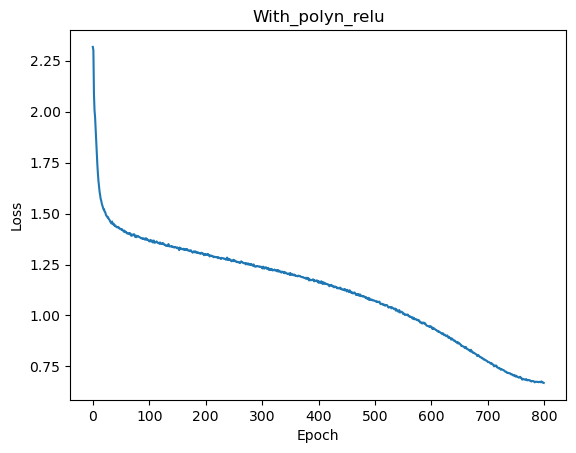

In [23]:
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")

plt.title(f"With_{PREFIX}")
plt.xlabel("Epoch")
plt.ylabel("Loss") 

plt.plot(training_losses) 
plt.savefig(f"training_losses_w_{PREFIX}.png") 
plt.show()


with open(f"{PREFIX}.txt", 'a') as f:
    f.write(f"Test loss: {test_loss:.2f}\n")
    f.write(f"Test accuracy: {correct / total * 100:.2f}%\n")